In [1]:
from geographical_spatial_strength_extensions import *
from os import listdir
import imp
import sys
import math
import scipy.io as sio
import matplotlib

In [6]:
imp.reload(sys.modules['geographical_spatial_strength_extensions'])

<module 'geographical_spatial_strength_extensions' from 'C:\\Users\\Andy\\Desktop\\Work\\github\\networks\\fitness\\geographical_spatial_strength_extensions.py'>

In [39]:
#full-width figure
# font = {'size'   : 20,
#         'family':'serif',
#         'sans-serif':['Helvetica']}

#half-width figure
font = {'size' : 30,
       'family': 'serif',
       'sans-serif': ['Helvetica']}
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)
marker_cycle = ['o', 's', '*', '+', 'd', '<', 'p']

In [3]:
def generate_rgg(n, r, size=1, pbc=False):
    '''
    generate a random geometric graph where and edge exists between nodes
    if they are within a distance of r from each other
    '''
    G = SimpleSpatialGraph(size=[size, size])
    for _ in range(n):
        G.add_node()
        
    distances = pbc_distances(G, pbc=pbc)
    
    for i in range(G.node_count):
        for j in range(i+1, G.node_count):
            if(distances[i][j] < r*size):
                G.add_edge(i, j)
                G[i][j]['distance'] = distances[i][j]
                
    return G

def generate_lattice(rows=5, columns=5, size=1):
    '''
    generate a lattice graph defined by number of rows and columns where
    number of nodes = rows * columns, and nodes that are north, south,
    east, west of each other will be adjacent
    '''
    G = SimpleSpatialGraph(size=[size, size])
    row_step = size / rows
    column_step = size / columns
    
    #create nodes
    for i in range(rows):
        for j in range(columns):
            G.add_node(coordinate=[j * column_step + 0.5 * column_step, i * row_step + 0.5 * row_step])
    
    #create edges
    #for each node, add edges to the right and above
    distances = []
    for i in range(rows):
        for j in range(columns):
            node_num = i * columns + j
            #edge above
            if(i < rows - 1):
                G.add_edge(node_num, node_num + columns)
            #edge to the right
            if(j < columns - 1):
                G.add_edge(node_num, node_num + 1)
    return G
    
def generate_web(branches=3, layers=5, radius=1):
    '''
    generate a web network (layered star network)
    branches: branches per layer
    layers: number of layers
    radius: radius per layer
    '''
    G = SimpleSpatialGraph(size=[2 * radius * layers, 2 * radius * layers])
    center = [radius * layers, radius * layers]
    G.add_node(coordinate=center)
    backstep = math.floor(branches / 2)
    
    append_to_node = 0
    branch_count = 0
    current_node = 0
    add_to_label = 1
        
    for n in range(1, layers):
        theta_step = 2 * math.pi / (branches ** n) 
        for i in range(-backstep, branches ** n - backstep):
            branch_count += 1
            current_node += 1
            
            theta = theta_step * i
            x = math.cos(theta) * n * radius + center[0]
            y = math.sin(theta) * n * radius + center[1]
            label = add_to_label + (i % branches ** n)
            G.add_node(label=label, coordinate=[x, y])
            G.add_edge(append_to_node, label)
            
            if(branch_count == branches):
                branch_count = 0
                append_to_node += 1
                
        add_to_label += branches ** n
    
    return G

def load_fungal_network(filename):
    data = sio.loadmat(open('datasets/Conductance/' + filename, 'rb'))
    xmin = np.min(data['coordinates'].T[0])
    xmax = np.max(data['coordinates'].T[0])
    ymin = np.min(data['coordinates'].T[1])
    ymax = np.max(data['coordinates'].T[1])
    g = SimpleSpatialGraph(size=[xmax-xmin, ymax-ymin])
    for coord in data['coordinates']:
        coord = [coord[0] - xmin, coord[1] - ymin]
        g.add_node(coordinate=coord)
    for node in range(g.node_count):
        for node2, strength in enumerate(data['A'][node].toarray()[0]):
            if(strength > 0):
                g.add_edge(node, node2)
    return g

def get_fungal_network_by_index(index):
    g = pickle.load(open('datasets/fungal_networks/' + listdir('datasets/fungal_networks')[88], 'rb'))
    return g

def load_city_network(continent, city):
    node_data = open('datasets/road_data_2km/' + continent + '/' + city + '_node.txt', 'r')
    edge_data = open('datasets/road_data_2km/' + continent + '/' + city + '_edge.txt', 'r')
    labels = []
    coordsx = []
    coordsy = []
    for line in node_data:
        data = line.split('\n')[0].split(' ')
        labels.append(data[0])
        coordsx.append(float(data[1]))
        coordsy.append(float(data[2]))
    xmin = np.min(coordsx)
    xmax = np.max(coordsx)
    ymin = np.min(coordsy)
    ymax = np.max(coordsy)
    coordsx = np.subtract(coordsx, xmin)
    coordsy = np.subtract(coordsy, ymin)
    g = SimpleSpatialGraph(size=[xmax-xmin, ymax-ymin])
    for i in range(len(labels)):
        g.add_node(coordinate=[coordsx[i], coordsy[i]])

    for line in edge_data:
        data = line.split('\n')[0].split(' ')
        g.add_edge(labels.index(data[0]), labels.index(data[1]))
    
    return g

def get_city_by_index(index):
    spatial_strengths = pickle.load(open('datasets/results/roads.pickle', 'rb'))
    regions = ['Africa', 'Asia', 'Europe', 'LatinAmerica', 'US']
    idx = index
    final_region = ''
    final_city = ''
    for region in regions:
        if(idx - len(spatial_strengths[region]) < 0):
            final_city = listdir('datasets/road_networks/' + region + '_2km')[idx]
            final_region = region
            idx = 9999
        else:
            idx = idx - len(spatial_strengths[region])
    print(final_region)
    print(final_city)
    g = pickle.load(open('datasets/road_networks/' + final_region + '_2km/' + final_city, 'rb'))
    return g

In [40]:
#generate graphs and collect results
nodes = [400, 500, 600, 700, 800, 900, 1000]
radii = [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.07, 0.09, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8]
trials = 50
count = 0
total_sets = len(nodes) * len(radii)

graph_n = []
graph_r = []
avg_spatial_strength = []

for n in nodes:
    for r in radii:
        count += 1
        print('set: ' + str(count) + ' out of ' + str(total_sets))
        results = {
            'graphs': [],
            'centralities': [],
            'spatial_strength': []
        }
        for i in range(trials):
            g = generate_rgg(n, r, pbc=False)
            centrality, spatial_strength = report_spatial_strength_centrality(g, pbc=False, ret=True, graph=False)
            results['spatial_strength'].append(spatial_strength)
        
        graph_n.append(n)
        graph_r.append(r)
        avg_spatial_strength.append(np.mean(results['spatial_strength']))
        
        pickle.dump(results, open('datasets/results/rgg/ssn_' + str(n) + '_r_' + str(r) + '.pickle', 'wb'))
        

set: 1 out of 140
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0458712774285
Average Spatial Strength: 0.0358099564225
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0423262848613
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0595617536779
Average Spatial Strength: 0.0
Average Spatial Strength: 0.519856516686
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0651036899053
Average Spatial Strength: 0.0448338521152
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0

Average Spatial Strength: 45.6413849878
Average Spatial Strength: 37.6181255763
Average Spatial Strength: 37.7658811053
Average Spatial Strength: 39.6865349751
Average Spatial Strength: 53.7322211779
Average Spatial Strength: 46.3789399295
Average Spatial Strength: 42.6317420051
Average Spatial Strength: 38.5708943803
Average Spatial Strength: 53.7569029719
Average Spatial Strength: 48.3148054241
Average Spatial Strength: 59.681855377
Average Spatial Strength: 41.3868393489
Average Spatial Strength: 50.7965439173
Average Spatial Strength: 39.4242762641
Average Spatial Strength: 35.6656542358
Average Spatial Strength: 34.8270657434
Average Spatial Strength: 41.3528155401
Average Spatial Strength: 39.3501885811
Average Spatial Strength: 47.7382527195
Average Spatial Strength: 40.1268951758
Average Spatial Strength: 40.205705071
Average Spatial Strength: 38.4950240793
Average Spatial Strength: 40.3760305227
Average Spatial Strength: 49.3106182194
Average Spatial Strength: 35.6909342584
Av

Average Spatial Strength: 22.3631135195
Average Spatial Strength: 22.2856052091
Average Spatial Strength: 22.2550549923
Average Spatial Strength: 22.8414261738
Average Spatial Strength: 22.468517227
Average Spatial Strength: 22.1545524188
Average Spatial Strength: 21.7947719031
Average Spatial Strength: 22.4381175132
Average Spatial Strength: 22.1537206006
Average Spatial Strength: 22.0594606878
Average Spatial Strength: 22.8984195026
Average Spatial Strength: 22.728341044
Average Spatial Strength: 21.7245555262
Average Spatial Strength: 22.2985690147
Average Spatial Strength: 21.8281264915
Average Spatial Strength: 22.3582408978
Average Spatial Strength: 22.6595315649
Average Spatial Strength: 22.6017784405
Average Spatial Strength: 22.4305946243
Average Spatial Strength: 22.5194257786
Average Spatial Strength: 22.7846060112
Average Spatial Strength: 21.7573721074
Average Spatial Strength: 22.0658195873
Average Spatial Strength: 22.2975175258
Average Spatial Strength: 22.1230146747
Av

Average Spatial Strength: 7.51069245369
Average Spatial Strength: 7.28595207769
Average Spatial Strength: 7.3886181536
Average Spatial Strength: 7.29806301737
Average Spatial Strength: 7.23001851992
Average Spatial Strength: 7.18780880383
Average Spatial Strength: 7.29175851059
Average Spatial Strength: 7.33529495979
Average Spatial Strength: 7.23047085821
Average Spatial Strength: 7.2689160549
Average Spatial Strength: 7.2559259438
Average Spatial Strength: 7.24162138357
Average Spatial Strength: 7.28417945998
Average Spatial Strength: 7.29645793127
Average Spatial Strength: 7.165617944
Average Spatial Strength: 7.20806376091
Average Spatial Strength: 7.18757373364
Average Spatial Strength: 7.28351953505
Average Spatial Strength: 7.20433845151
Average Spatial Strength: 7.19329601727
Average Spatial Strength: 7.37901388773
Average Spatial Strength: 7.25111349143
Average Spatial Strength: 7.32215580808
Average Spatial Strength: 7.22093620755
Average Spatial Strength: 7.36133785542
Avera

Average Spatial Strength: 4.35280930013
Average Spatial Strength: 4.3349224131
Average Spatial Strength: 4.28919873545
Average Spatial Strength: 4.29617543659
Average Spatial Strength: 4.3016636092
Average Spatial Strength: 4.318923014
Average Spatial Strength: 4.28591904597
Average Spatial Strength: 4.30419817343
Average Spatial Strength: 4.42426478432
Average Spatial Strength: 4.27779080405
Average Spatial Strength: 4.34015246241
Average Spatial Strength: 4.30524245874
Average Spatial Strength: 4.34468372546
Average Spatial Strength: 4.32558190685
Average Spatial Strength: 4.27005136902
Average Spatial Strength: 4.28554338847
Average Spatial Strength: 4.33968651899
Average Spatial Strength: 4.29053045274
Average Spatial Strength: 4.36663810177
Average Spatial Strength: 4.30968775634
Average Spatial Strength: 4.33172950581
Average Spatial Strength: 4.27255750573
Average Spatial Strength: 4.33987079913
Average Spatial Strength: 4.2531273195
Average Spatial Strength: 4.3194747057
Averag

Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0367955758576
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0310228461581
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
Average Spatial Strength: 0.0
set: 22 out of 140
Average Spatial Strength: 0.346265927517
Average Spatial Strength: 0.744505564136
Average Spatial Strength: 0.120157137546
Average Spatial Strength: 0.0
Average Spatial Strength: 0.236272974937
Average Spatial Strength: 1.14284325709
Average Spatial Strength: 0.0445137534609
Average Spatial Strength: 0.0342128085664
Average Spatial Strength: 0.407366013939
Average Spatial Strength: 0.154731545743
Average Spatial S

Average Spatial Strength: 54.5691207709
Average Spatial Strength: 56.7185882436
Average Spatial Strength: 50.8965715303
Average Spatial Strength: 62.2108452936
Average Spatial Strength: 48.4234995599
Average Spatial Strength: 60.8287725449
Average Spatial Strength: 56.6819554276
Average Spatial Strength: 113.431501137
Average Spatial Strength: 54.6953817508
Average Spatial Strength: 62.1558460556
Average Spatial Strength: 52.8527743251
Average Spatial Strength: 57.1471647799
set: 26 out of 140
Average Spatial Strength: 47.6507683229
Average Spatial Strength: 59.5848005757
Average Spatial Strength: 52.1707297426
Average Spatial Strength: 51.7182925489
Average Spatial Strength: 45.4293376611
Average Spatial Strength: 50.4535420698
Average Spatial Strength: 54.5595937013
Average Spatial Strength: 49.2194095077
Average Spatial Strength: 51.8668575162
Average Spatial Strength: 45.2202533738
Average Spatial Strength: 52.2568958905
Average Spatial Strength: 46.4305824742
Average Spatial Stren

Average Spatial Strength: 21.4806767353
Average Spatial Strength: 21.9773955543
Average Spatial Strength: 22.077531574
Average Spatial Strength: 22.7314125406
Average Spatial Strength: 21.5719294553
Average Spatial Strength: 22.4443364419
Average Spatial Strength: 22.6637678103
Average Spatial Strength: 23.2232644877
set: 30 out of 140
Average Spatial Strength: 15.2002435518
Average Spatial Strength: 14.6852136262
Average Spatial Strength: 14.3263590357
Average Spatial Strength: 14.6788185714
Average Spatial Strength: 14.7584782023
Average Spatial Strength: 14.7600527771
Average Spatial Strength: 14.7090531651
Average Spatial Strength: 14.6477435673
Average Spatial Strength: 14.6343993541
Average Spatial Strength: 14.8546955357
Average Spatial Strength: 14.6333842507
Average Spatial Strength: 14.8280735379
Average Spatial Strength: 14.5053266169
Average Spatial Strength: 14.773193505
Average Spatial Strength: 14.3347669884
Average Spatial Strength: 14.715243202
Average Spatial Strength

Average Spatial Strength: 7.28921446894
Average Spatial Strength: 7.27708786621
Average Spatial Strength: 7.22186665348
Average Spatial Strength: 7.35555563701
set: 34 out of 140
Average Spatial Strength: 6.21941954117
Average Spatial Strength: 6.17466175944
Average Spatial Strength: 6.19571109954
Average Spatial Strength: 6.20797045489
Average Spatial Strength: 6.25771057891
Average Spatial Strength: 6.25427033466
Average Spatial Strength: 6.29599740411
Average Spatial Strength: 6.21000954518
Average Spatial Strength: 6.22682338574
Average Spatial Strength: 6.18978881881
Average Spatial Strength: 6.15312052894
Average Spatial Strength: 6.16363305954
Average Spatial Strength: 6.31180655446
Average Spatial Strength: 6.22609044673
Average Spatial Strength: 6.15405428975
Average Spatial Strength: 6.21990267653
Average Spatial Strength: 6.2298587539
Average Spatial Strength: 6.17490788048
Average Spatial Strength: 6.16086990624
Average Spatial Strength: 6.21247377703
Average Spatial Streng

Average Spatial Strength: 3.67148978058
Average Spatial Strength: 3.69137785419
Average Spatial Strength: 3.68603161144
Average Spatial Strength: 3.65769732752
Average Spatial Strength: 3.67035633857
Average Spatial Strength: 3.67959290442
Average Spatial Strength: 3.68443762038
Average Spatial Strength: 3.68667478124
Average Spatial Strength: 3.64502928823
Average Spatial Strength: 3.6772434065
Average Spatial Strength: 3.66107670458
Average Spatial Strength: 3.65790765019
Average Spatial Strength: 3.68194518412
Average Spatial Strength: 3.70243646009
Average Spatial Strength: 3.68223297993
Average Spatial Strength: 3.67680605002
Average Spatial Strength: 3.6816128567
Average Spatial Strength: 3.6732622405
Average Spatial Strength: 3.68369767086
Average Spatial Strength: 3.68088634074
Average Spatial Strength: 3.67831311379
Average Spatial Strength: 3.6845319887
Average Spatial Strength: 3.68355547369
Average Spatial Strength: 3.69826992024
Average Spatial Strength: 3.67057032245
Aver

Average Spatial Strength: 0.199793901711
Average Spatial Strength: 0.269861971388
Average Spatial Strength: 0.0435291683331
Average Spatial Strength: 0.876254653654
Average Spatial Strength: 0.252519262801
Average Spatial Strength: 0.931604644013
Average Spatial Strength: 0.535682043137
Average Spatial Strength: 0.744465941021
Average Spatial Strength: 0.0203195095525
Average Spatial Strength: 0.210960149951
Average Spatial Strength: 0.147360312647
Average Spatial Strength: 0.187455163249
Average Spatial Strength: 0.332739249218
Average Spatial Strength: 0.112605646627
Average Spatial Strength: 0.178667881629
Average Spatial Strength: 0.0607750392076
Average Spatial Strength: 0.150049192051
Average Spatial Strength: 0.188946054779
Average Spatial Strength: 0.297053592394
Average Spatial Strength: 0.127771582534
Average Spatial Strength: 0.279488127347
Average Spatial Strength: 0.572011492491
Average Spatial Strength: 0.626509003195
Average Spatial Strength: 0.118757856664
Average Spati

Average Spatial Strength: 49.5405578792
Average Spatial Strength: 46.9101896867
Average Spatial Strength: 43.3174923483
Average Spatial Strength: 47.1230227567
Average Spatial Strength: 48.0786806784
Average Spatial Strength: 50.7318980662
Average Spatial Strength: 45.8809150658
Average Spatial Strength: 48.9050994725
Average Spatial Strength: 47.0157645828
Average Spatial Strength: 48.120809105
Average Spatial Strength: 50.5393996547
Average Spatial Strength: 48.6345228201
Average Spatial Strength: 48.0008155184
Average Spatial Strength: 49.9846324671
Average Spatial Strength: 50.9142055708
Average Spatial Strength: 49.2927879649
Average Spatial Strength: 50.5955118401
Average Spatial Strength: 49.9063980399
Average Spatial Strength: 46.0562334608
Average Spatial Strength: 54.5459631719
Average Spatial Strength: 49.9012060236
Average Spatial Strength: 49.7491640407
Average Spatial Strength: 46.8497181288
Average Spatial Strength: 47.9985089501
Average Spatial Strength: 60.5444132674
A

Average Spatial Strength: 14.8468004499
Average Spatial Strength: 14.3784993569
Average Spatial Strength: 14.6315819212
Average Spatial Strength: 14.7153945634
Average Spatial Strength: 14.6853887902
Average Spatial Strength: 14.3806051407
Average Spatial Strength: 14.6411464201
Average Spatial Strength: 14.7967829699
Average Spatial Strength: 14.7117587657
Average Spatial Strength: 14.6243308809
Average Spatial Strength: 14.6034046577
Average Spatial Strength: 14.6304446052
Average Spatial Strength: 14.5793648167
Average Spatial Strength: 14.5653224974
Average Spatial Strength: 14.5712448486
Average Spatial Strength: 14.4618371737
Average Spatial Strength: 14.5014683181
Average Spatial Strength: 14.6104411594
Average Spatial Strength: 14.5753803443
Average Spatial Strength: 14.4730531942
Average Spatial Strength: 14.5924574049
Average Spatial Strength: 14.621692531
Average Spatial Strength: 14.6421565685
Average Spatial Strength: 14.7706610463
Average Spatial Strength: 14.2594559674
A

Average Spatial Strength: 6.22466806064
Average Spatial Strength: 6.24302334322
Average Spatial Strength: 6.28428220329
Average Spatial Strength: 6.19706906396
Average Spatial Strength: 6.16615278998
Average Spatial Strength: 6.26088779784
Average Spatial Strength: 6.23140103179
Average Spatial Strength: 6.20769503114
Average Spatial Strength: 6.29263777849
Average Spatial Strength: 6.29764811539
Average Spatial Strength: 6.21465717947
Average Spatial Strength: 6.18555801715
Average Spatial Strength: 6.19794335176
Average Spatial Strength: 6.24668872719
Average Spatial Strength: 6.20482935724
Average Spatial Strength: 6.2877769449
Average Spatial Strength: 6.22114344049
Average Spatial Strength: 6.19720450105
Average Spatial Strength: 6.20626864586
Average Spatial Strength: 6.21463102144
Average Spatial Strength: 6.20628080262
Average Spatial Strength: 6.14236056014
Average Spatial Strength: 6.15164835154
Average Spatial Strength: 6.21182043545
Average Spatial Strength: 6.20785687701
A

Average Spatial Strength: 3.68808929666
Average Spatial Strength: 3.67196500941
Average Spatial Strength: 3.65547938572
Average Spatial Strength: 3.67622426349
Average Spatial Strength: 3.66834315001
Average Spatial Strength: 3.67368970558
Average Spatial Strength: 3.68143416259
Average Spatial Strength: 3.65366075572
Average Spatial Strength: 3.68233842948
Average Spatial Strength: 3.67487395438
Average Spatial Strength: 3.66067880871
Average Spatial Strength: 3.66922178143
Average Spatial Strength: 3.67009060825
Average Spatial Strength: 3.69459025751
Average Spatial Strength: 3.65905336726
Average Spatial Strength: 3.69571829449
Average Spatial Strength: 3.66128961701
Average Spatial Strength: 3.69186766878
Average Spatial Strength: 3.68716898111
Average Spatial Strength: 3.67141789772
Average Spatial Strength: 3.68115250276
Average Spatial Strength: 3.66830440532
Average Spatial Strength: 3.66163424532
Average Spatial Strength: 3.67973592686
Average Spatial Strength: 3.66244300776


Average Spatial Strength: 1.12234364316
Average Spatial Strength: 0.975475782399
Average Spatial Strength: 0.249260213882
Average Spatial Strength: 0.263791276525
Average Spatial Strength: 0.388582678934
Average Spatial Strength: 0.289618459041
Average Spatial Strength: 0.94470003062
Average Spatial Strength: 0.1578999226
Average Spatial Strength: 0.229538256151
Average Spatial Strength: 0.0175735826696
Average Spatial Strength: 0.553747151582
Average Spatial Strength: 0.124009153545
Average Spatial Strength: 0.120573979136
Average Spatial Strength: 0.186757207817
Average Spatial Strength: 0.243969662847
Average Spatial Strength: 0.384869235168
Average Spatial Strength: 0.27390745218
set: 63 out of 140
Average Spatial Strength: 0.738701654989
Average Spatial Strength: 0.727960191817
Average Spatial Strength: 1.72971329054
Average Spatial Strength: 4.15586853684
Average Spatial Strength: 1.43233764192
Average Spatial Strength: 0.997320574582
Average Spatial Strength: 1.49941806023
Avera

Average Spatial Strength: 48.9574613317
Average Spatial Strength: 52.1156400198
Average Spatial Strength: 45.0121771095
Average Spatial Strength: 47.6927697786
Average Spatial Strength: 46.5357261143
Average Spatial Strength: 53.8066214427
Average Spatial Strength: 47.2865827921
Average Spatial Strength: 44.7703505392
Average Spatial Strength: 51.5633555341
Average Spatial Strength: 47.0312043654
Average Spatial Strength: 50.4946822207
Average Spatial Strength: 45.7517109364
Average Spatial Strength: 48.0239999267
Average Spatial Strength: 51.0293314625
set: 67 out of 140
Average Spatial Strength: 33.1087042693
Average Spatial Strength: 31.6292242624
Average Spatial Strength: 31.1236558885
Average Spatial Strength: 31.0659872103
Average Spatial Strength: 31.991104422
Average Spatial Strength: 31.1499085815
Average Spatial Strength: 32.3271990765
Average Spatial Strength: 31.3733386598
Average Spatial Strength: 32.661211156
Average Spatial Strength: 31.9378796522
Average Spatial Strengt

Average Spatial Strength: 14.9275279478
Average Spatial Strength: 14.5191126452
Average Spatial Strength: 14.7774215471
Average Spatial Strength: 14.5754698687
Average Spatial Strength: 14.3321282809
Average Spatial Strength: 14.7851962194
Average Spatial Strength: 14.431486846
Average Spatial Strength: 14.5643621658
Average Spatial Strength: 14.4805773077
Average Spatial Strength: 14.5032891164
set: 71 out of 140
Average Spatial Strength: 10.9599579063
Average Spatial Strength: 10.986048647
Average Spatial Strength: 11.0833447733
Average Spatial Strength: 10.923470748
Average Spatial Strength: 10.8551301056
Average Spatial Strength: 10.8637755261
Average Spatial Strength: 11.0311252129
Average Spatial Strength: 10.9631911656
Average Spatial Strength: 10.9344522096
Average Spatial Strength: 11.0366842801
Average Spatial Strength: 10.956466767
Average Spatial Strength: 11.0599265659
Average Spatial Strength: 10.873643565
Average Spatial Strength: 10.8525280673
Average Spatial Strength: 

Average Spatial Strength: 6.16106947072
Average Spatial Strength: 6.21546677667
Average Spatial Strength: 6.21538076878
Average Spatial Strength: 6.18586279862
Average Spatial Strength: 6.18312606948
Average Spatial Strength: 6.22272966063
set: 75 out of 140
Average Spatial Strength: 5.36053860278
Average Spatial Strength: 5.38174410226
Average Spatial Strength: 5.41255649212
Average Spatial Strength: 5.46082112093
Average Spatial Strength: 5.39637878715
Average Spatial Strength: 5.35457293189
Average Spatial Strength: 5.43499672165
Average Spatial Strength: 5.37826676573
Average Spatial Strength: 5.43487343048
Average Spatial Strength: 5.3933388671
Average Spatial Strength: 5.36723568924
Average Spatial Strength: 5.37756831183
Average Spatial Strength: 5.38343088088
Average Spatial Strength: 5.38548110675
Average Spatial Strength: 5.50712325728
Average Spatial Strength: 5.39312731663
Average Spatial Strength: 5.36131707169
Average Spatial Strength: 5.39986911793
Average Spatial Streng

Average Spatial Strength: 3.67574853935
Average Spatial Strength: 3.66377651537
set: 79 out of 140
Average Spatial Strength: 3.28471373984
Average Spatial Strength: 3.31236044738
Average Spatial Strength: 3.32654191212
Average Spatial Strength: 3.3012319643
Average Spatial Strength: 3.30047183071
Average Spatial Strength: 3.29476319632
Average Spatial Strength: 3.3086964068
Average Spatial Strength: 3.29484511184
Average Spatial Strength: 3.30760539271
Average Spatial Strength: 3.28380106213
Average Spatial Strength: 3.28699519958
Average Spatial Strength: 3.27414976067
Average Spatial Strength: 3.30605524996
Average Spatial Strength: 3.3116661647
Average Spatial Strength: 3.28338653532
Average Spatial Strength: 3.29314511136
Average Spatial Strength: 3.29639734249
Average Spatial Strength: 3.27832797656
Average Spatial Strength: 3.27677275742
Average Spatial Strength: 3.30454430327
Average Spatial Strength: 3.29717717338
Average Spatial Strength: 3.28916946174
Average Spatial Strength

Average Spatial Strength: 2.27418313116
Average Spatial Strength: 1.72285182567
Average Spatial Strength: 1.87941461382
Average Spatial Strength: 2.54685484752
Average Spatial Strength: 3.27674660666
Average Spatial Strength: 1.68251052377
Average Spatial Strength: 2.20960604744
Average Spatial Strength: 2.39718026032
Average Spatial Strength: 1.08867123294
Average Spatial Strength: 3.60892510707
Average Spatial Strength: 2.31085581903
Average Spatial Strength: 2.16815104171
Average Spatial Strength: 2.34884994271
Average Spatial Strength: 1.22339321811
Average Spatial Strength: 2.04428073162
Average Spatial Strength: 1.42752567315
Average Spatial Strength: 1.3902794459
Average Spatial Strength: 1.29097496114
Average Spatial Strength: 3.61337349144
Average Spatial Strength: 3.81671821892
Average Spatial Strength: 2.20978500477
Average Spatial Strength: 2.15044651887
Average Spatial Strength: 0.965230751778
Average Spatial Strength: 2.76490403135
Average Spatial Strength: 2.11296805332


Average Spatial Strength: 31.603199097
Average Spatial Strength: 31.7551014229
Average Spatial Strength: 31.9319511857
Average Spatial Strength: 31.234934203
Average Spatial Strength: 31.558322767
Average Spatial Strength: 31.8718277645
Average Spatial Strength: 32.0947341819
Average Spatial Strength: 31.5496793861
Average Spatial Strength: 32.1465883369
Average Spatial Strength: 31.8703294518
Average Spatial Strength: 32.2569577049
Average Spatial Strength: 31.842869986
Average Spatial Strength: 31.4568649748
Average Spatial Strength: 31.5613547945
Average Spatial Strength: 30.9269426251
Average Spatial Strength: 32.5563297763
Average Spatial Strength: 31.5991108991
Average Spatial Strength: 30.988573454
Average Spatial Strength: 31.4576956268
Average Spatial Strength: 31.3367985099
Average Spatial Strength: 30.8039904784
Average Spatial Strength: 31.101300992
Average Spatial Strength: 31.1996726343
Average Spatial Strength: 32.2109785749
Average Spatial Strength: 32.0679395922
Averag

Average Spatial Strength: 10.9643152414
Average Spatial Strength: 11.1839436972
Average Spatial Strength: 10.8983583128
Average Spatial Strength: 11.0255545919
Average Spatial Strength: 10.9063007923
Average Spatial Strength: 10.8338232177
Average Spatial Strength: 10.9707982605
Average Spatial Strength: 10.726159587
Average Spatial Strength: 11.0663918737
Average Spatial Strength: 10.9773142381
Average Spatial Strength: 10.8940315826
Average Spatial Strength: 10.8033813244
Average Spatial Strength: 10.9145530926
Average Spatial Strength: 10.8837434881
Average Spatial Strength: 10.8833504851
Average Spatial Strength: 10.8616067179
Average Spatial Strength: 11.0296699071
Average Spatial Strength: 10.9811528492
Average Spatial Strength: 10.9921126656
Average Spatial Strength: 10.8333238679
Average Spatial Strength: 10.9639354888
Average Spatial Strength: 11.1021248922
Average Spatial Strength: 10.9055723651
Average Spatial Strength: 11.0568452582
Average Spatial Strength: 11.0241870066
A

Average Spatial Strength: 5.42813908603
Average Spatial Strength: 5.42368292808
Average Spatial Strength: 5.36404964006
Average Spatial Strength: 5.40070746692
Average Spatial Strength: 5.40299505129
Average Spatial Strength: 5.34523899768
Average Spatial Strength: 5.44689750349
Average Spatial Strength: 5.36702247814
Average Spatial Strength: 5.39430851522
Average Spatial Strength: 5.36778747754
Average Spatial Strength: 5.42190905097
Average Spatial Strength: 5.41116705473
Average Spatial Strength: 5.41014926449
Average Spatial Strength: 5.44540235091
Average Spatial Strength: 5.3811094482
Average Spatial Strength: 5.38582030153
Average Spatial Strength: 5.44437940597
Average Spatial Strength: 5.45385213327
Average Spatial Strength: 5.39837571657
Average Spatial Strength: 5.40264403536
Average Spatial Strength: 5.3782520487
Average Spatial Strength: 5.4118563854
Average Spatial Strength: 5.46760304503
Average Spatial Strength: 5.43296131768
Average Spatial Strength: 5.44036976418
Ave

Average Spatial Strength: 3.3076698606
Average Spatial Strength: 3.28789309115
Average Spatial Strength: 3.31640168619
Average Spatial Strength: 3.31890123446
Average Spatial Strength: 3.27925979572
Average Spatial Strength: 3.29132255023
Average Spatial Strength: 3.2936439682
Average Spatial Strength: 3.2951858483
Average Spatial Strength: 3.30097595852
Average Spatial Strength: 3.28613091352
Average Spatial Strength: 3.28238865497
Average Spatial Strength: 3.28810912629
Average Spatial Strength: 3.2879123446
Average Spatial Strength: 3.27862139762
Average Spatial Strength: 3.30807384989
Average Spatial Strength: 3.30538563318
Average Spatial Strength: 3.30776804894
Average Spatial Strength: 3.3003837926
Average Spatial Strength: 3.31882315125
Average Spatial Strength: 3.29673517098
Average Spatial Strength: 3.30257273725
Average Spatial Strength: 3.28366969366
Average Spatial Strength: 3.29190233156
Average Spatial Strength: 3.30998925003
Average Spatial Strength: 3.2971841811
Averag

KeyboardInterrupt: 

In [177]:
#generate graphs and collect results
#don't save the graphs only collect final spatial strengths

nodes = [10, 50, 100, 300, 500, 700, 900, 1000]
radii = [0.01, 0.02, 0.03, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5]
trials = 20
count = 0
total_sets = len(nodes) * len(radii)

graph_n = []
graph_r = []
avg_spatial_strength = []
results = {}

for n in nodes:
    for r in radii:
        results['n_' + str(n) + '_r_' + str(r)] = []
        count += 1
        print('set: ' + str(count) + ' out of ' + str(total_sets) + '. n: ' + str(n) + ', r: ' + str(r))
        for i in range(trials):
            g = generate_rgg(n, r, pbc=False)
            centrality, spatial_strength = report_spatial_strength_centrality(g, pbc=False, ret=True, graph=False, print_result=False, normalized=4)
            results['n_' + str(n) + '_r_' + str(r)].append(spatial_strength)
        
        graph_n.append(n)
        graph_r.append(r)
        avg_spatial_strength.append(np.mean(results['n_' + str(n) + '_r_' + str(r)]))
        print(np.mean(results['n_' + str(n) + '_r_' + str(r)]))
        
results['graph_n'] = graph_n
results['graph_r'] = graph_r
results['avg_spatial_strengths'] = avg_spatial_strength

set: 1 out of 96. n: 10, r: 0.01
0.0
set: 2 out of 96. n: 10, r: 0.02
0.0
set: 3 out of 96. n: 10, r: 0.03
0.004
set: 4 out of 96. n: 10, r: 0.05
0.0200712379304
set: 5 out of 96. n: 10, r: 0.07
0.0307467844195
set: 6 out of 96. n: 10, r: 0.1
0.0877892894072
set: 7 out of 96. n: 10, r: 0.15
0.247312678778
set: 8 out of 96. n: 10, r: 0.2
0.409578340457
set: 9 out of 96. n: 10, r: 0.25
0.871692913356
set: 10 out of 96. n: 10, r: 0.3
0.910444505732
set: 11 out of 96. n: 10, r: 0.4
1.08459290471
set: 12 out of 96. n: 10, r: 0.5
0.947435867461
set: 13 out of 96. n: 50, r: 0.01
0.00132945713139
set: 14 out of 96. n: 50, r: 0.02
0.00447483562516
set: 15 out of 96. n: 50, r: 0.03
0.0232131824078
set: 16 out of 96. n: 50, r: 0.05
0.146964751954
set: 17 out of 96. n: 50, r: 0.07
0.420906222109
set: 18 out of 96. n: 50, r: 0.1
0.759344370164
set: 19 out of 96. n: 50, r: 0.15
1.09700896
set: 20 out of 96. n: 50, r: 0.2
1.24775055362
set: 21 out of 96. n: 50, r: 0.25
1.0386684765
set: 22 out of 96.

In [179]:
pickle.dump(results, open('datasets/results/rgg/rgg_n10-1000_r001-05.pickle', 'wb'))

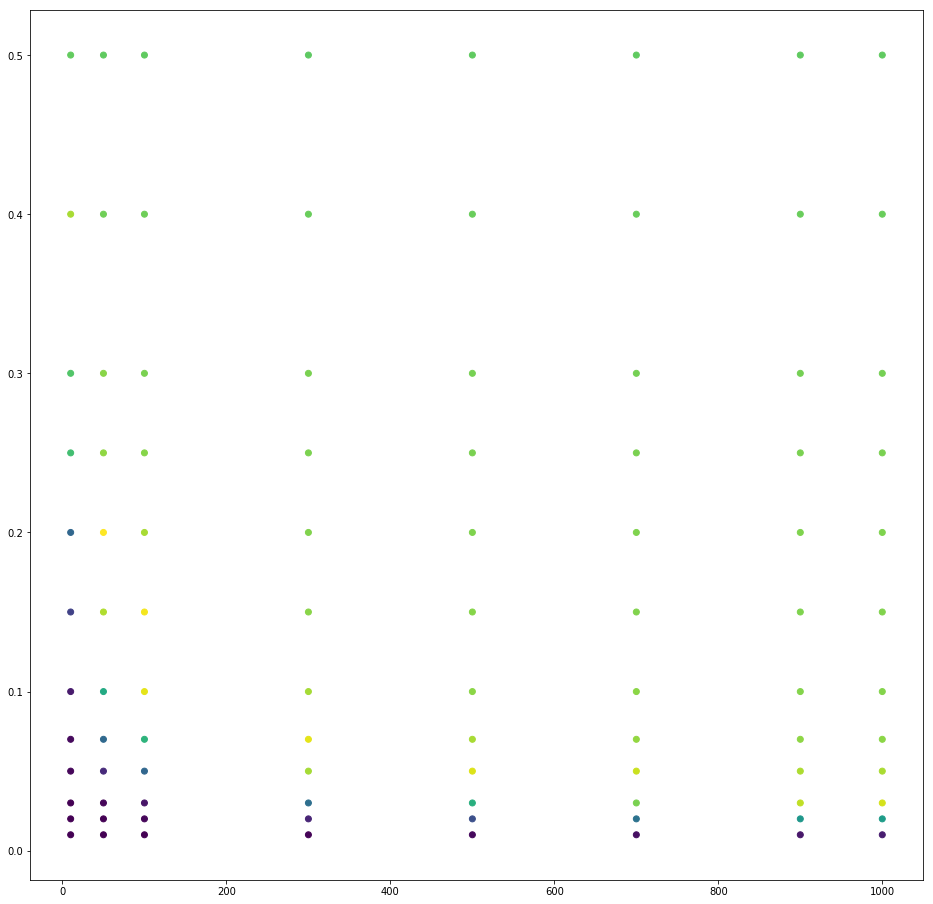

In [180]:
results = pickle.load(open('datasets/results/rgg/rgg_n10-1000_r001-05.pickle', 'rb'))
plt.figure(figsize=(16, 16))
plt.scatter(results['graph_n'], results['graph_r'], c=results['avg_spatial_strengths'], cmap='viridis')

In [3]:
#generate more granulated results around interesting area

nodes = [10, 50, 100, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
radii = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
trials = 20
count = 0
total_sets = len(nodes) * len(radii)

graph_n = []
graph_r = []
avg_spatial_strength = []
results = {}

for n in nodes:
    for r in radii:
        results['n_' + str(n) + '_r_' + str(r)] = []
        count += 1
        print('set: ' + str(count) + ' out of ' + str(total_sets) + '. n: ' + str(n) + ', r: ' + str(r))
        for i in range(trials):
            g = generate_rgg(n, r, pbc=False)
            centrality, spatial_strength = report_spatial_strength_centrality2(g, pbc=False, ret=True, graph=False, print_result=False, normalized=True)
            results['n_' + str(n) + '_r_' + str(r)].append(spatial_strength)
        
        graph_n.append(n)
        graph_r.append(r)
        avg_spatial_strength.append(np.mean(results['n_' + str(n) + '_r_' + str(r)]))
        print(np.mean(results['n_' + str(n) + '_r_' + str(r)]))
        
results['graph_n'] = graph_n
results['graph_r'] = graph_r
results['avg_spatial_strengths'] = avg_spatial_strength

set: 1 out of 200. n: 10, r: 0.01
0.0
set: 2 out of 200. n: 10, r: 0.02
0.184860145797
set: 3 out of 200. n: 10, r: 0.03
0.321109547074
set: 4 out of 200. n: 10, r: 0.04
0.37124387669
set: 5 out of 200. n: 10, r: 0.05
0.234465283177
set: 6 out of 200. n: 10, r: 0.06
0.570997985799
set: 7 out of 200. n: 10, r: 0.07
0.996292578898
set: 8 out of 200. n: 10, r: 0.08
1.44262449316
set: 9 out of 200. n: 10, r: 0.09
1.59528179172
set: 10 out of 200. n: 10, r: 0.1
5.52680357359
set: 11 out of 200. n: 50, r: 0.01
0.315518534635
set: 12 out of 200. n: 50, r: 0.02
1.64748620102
set: 13 out of 200. n: 50, r: 0.03
1.67371613061
set: 14 out of 200. n: 50, r: 0.04
3.62644749898
set: 15 out of 200. n: 50, r: 0.05
6.772073847
set: 16 out of 200. n: 50, r: 0.06
9.69681657629
set: 17 out of 200. n: 50, r: 0.07
13.0844492724
set: 18 out of 200. n: 50, r: 0.08
12.8700836395
set: 19 out of 200. n: 50, r: 0.09
17.2059873445
set: 20 out of 200. n: 50, r: 0.1
20.3632689218
set: 21 out of 200. n: 100, r: 0.01
0

48.5666965298
set: 166 out of 200. n: 850, r: 0.06
37.908035116
set: 167 out of 200. n: 850, r: 0.07
31.8513278275
set: 168 out of 200. n: 850, r: 0.08
27.44636097
set: 169 out of 200. n: 850, r: 0.09
24.33555094
set: 170 out of 200. n: 850, r: 0.1
21.8872215137
set: 171 out of 200. n: 900, r: 0.01
18.0130487149
set: 172 out of 200. n: 900, r: 0.02
66.9597244598
set: 173 out of 200. n: 900, r: 0.03
80.3882915918
set: 174 out of 200. n: 900, r: 0.04
61.2146355078
set: 175 out of 200. n: 900, r: 0.05
46.2262588153
set: 176 out of 200. n: 900, r: 0.06
37.2368369481
set: 177 out of 200. n: 900, r: 0.07
31.7178250533
set: 178 out of 200. n: 900, r: 0.08
27.3883147408
set: 179 out of 200. n: 900, r: 0.09
24.3260656098
set: 180 out of 200. n: 900, r: 0.1
21.8308103039
set: 181 out of 200. n: 950, r: 0.01
18.5362360758
set: 182 out of 200. n: 950, r: 0.02
71.6289954726
set: 183 out of 200. n: 950, r: 0.03
81.5982826636
set: 184 out of 200. n: 950, r: 0.04
63.2286148696
set: 185 out of 200. n: 

In [93]:
np.random.randint(-25, 25)

12

In [97]:
#generate more granulated results around interesting area
all_scatter['rgg'] = {
    'ns': [],
    'strengths': []
}
nodes = [50, 100, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]
radii = 0.07
trials = 20
count = 0

for n in nodes:
    
    count += 1
    for i in range(trials):
        g = generate_rgg(n + np.random.randint(-25, 25), radii, pbc=False)
        centrality, spatial_strength = report_spatial_strength_centrality2(g, pbc=False, ret=True, graph=False, print_result=False, normalized=True)
        all_scatter['rgg']['ns'].append(len(g.nodes))
        all_scatter['rgg']['strengths'].append(spatial_strength)
        

In [4]:
pickle.dump(results, open('datasets/results/rgg/rgg_n10-1000_r001-01_2_2.pickle', 'wb'))

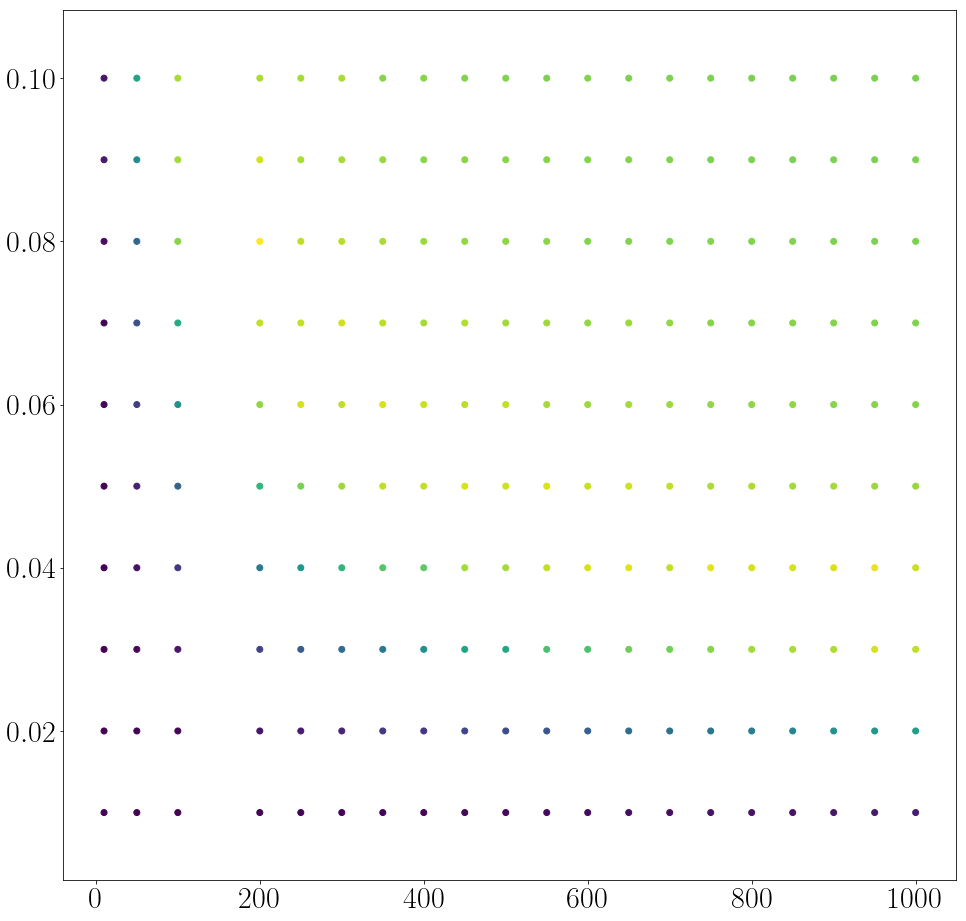

In [25]:
results = pickle.load(open('datasets/results/rgg/rgg_n10-1000_r001-01_2.pickle', 'rb'))
plt.figure(figsize=(16, 16))
plt.scatter(results['graph_n'], results['graph_r'], c=results['avg_spatial_strengths'], cmap='viridis')

In [23]:
pickle.dump(rgg, open('spatial_rgg_example', 'wb'))

Average Spatial Strength: 1.44583315207


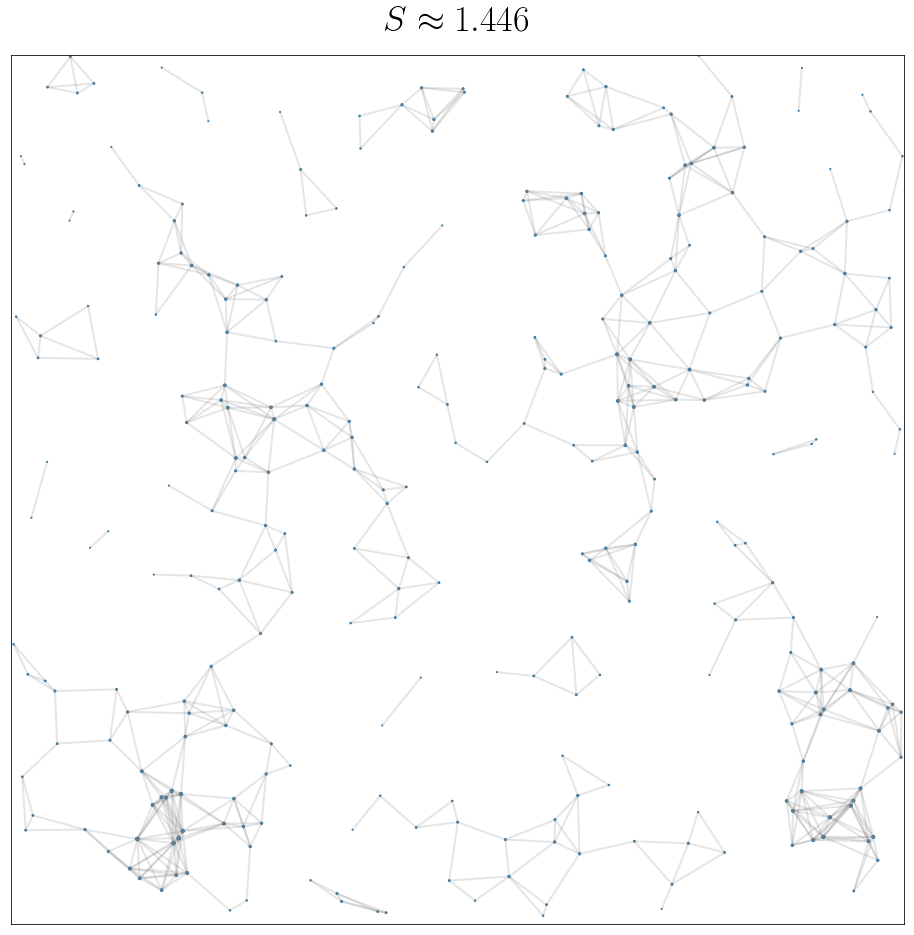

In [7]:
rgg = generate_rgg(300, 0.07)
graph_spatial_network_plot_valued(rgg, graph_edges=True, pbc=False, ss_title=True)

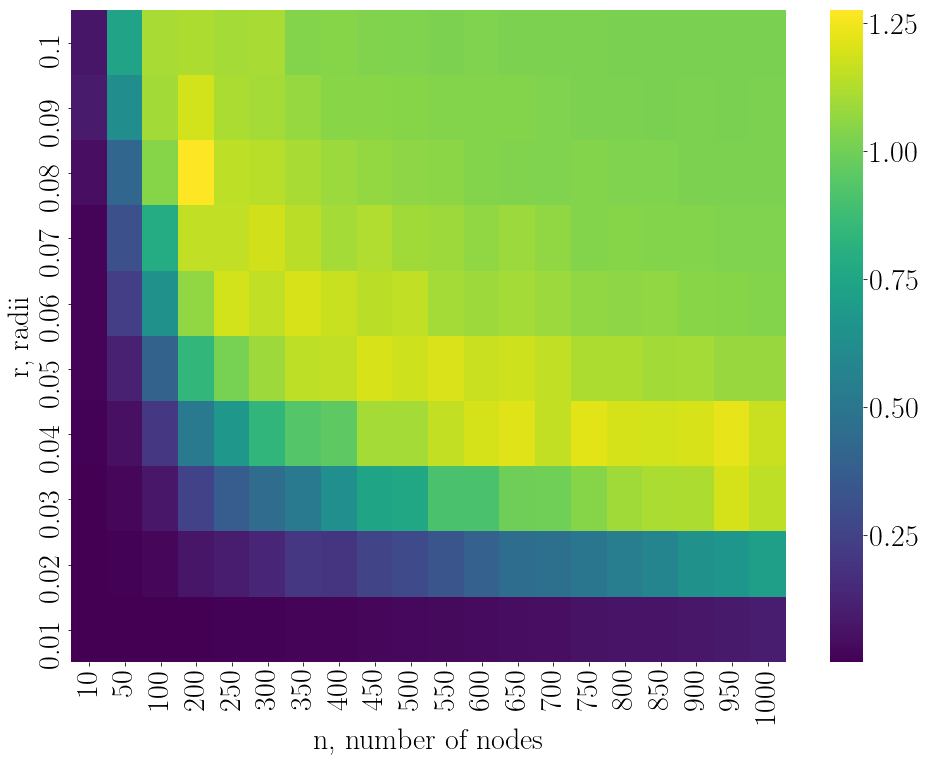

In [33]:

heat = pd.DataFrame(columns=['graph_n', 'graph_r', 'avg_spatial_strengths'])
heat['graph_n'] = results['graph_n']
heat['graph_r'] = results['graph_r']
heat['avg_spatial_strengths'] = results['avg_spatial_strengths']
heatmap = heat.pivot('graph_r', 'graph_n', 'avg_spatial_strengths')
heatmap = heatmap.iloc[::-1]
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(heatmap, cmap='viridis')

ax.set_xlabel('n, number of nodes')
ax.set_ylabel('r, radii')
plt.savefig('figures/rgg_spatial_strength.pdf', bbox_inches='tight')

In [29]:
rows = [5, 10, 15, 20, 25, 30]
columns = rows
graph_rows = []
graph_cols = []
spatial_strengths = []
for row in rows:
    for col in columns:
        print('row: ', row, ', col: ', col)
        g = generate_lattice(row, col, size=10)
        spatial_strength = spatial_strength_centrality(g, pbc=False)[1]
        spatial_strengths.append(spatial_strength)
        graph_rows.append(row)
        graph_cols.append(col)


row:  5 , col:  5
row:  5 , col:  10
row:  5 , col:  15
row:  5 , col:  20
row:  5 , col:  25
row:  5 , col:  30
row:  10 , col:  5
row:  10 , col:  10
row:  10 , col:  15
row:  10 , col:  20
row:  10 , col:  25
row:  10 , col:  30
row:  15 , col:  5
row:  15 , col:  10
row:  15 , col:  15
row:  15 , col:  20
row:  15 , col:  25
row:  15 , col:  30
row:  20 , col:  5
row:  20 , col:  10
row:  20 , col:  15
row:  20 , col:  20
row:  20 , col:  25
row:  20 , col:  30
row:  25 , col:  5
row:  25 , col:  10
row:  25 , col:  15
row:  25 , col:  20
row:  25 , col:  25
row:  25 , col:  30
row:  30 , col:  5
row:  30 , col:  10
row:  30 , col:  15
row:  30 , col:  20
row:  30 , col:  25
row:  30 , col:  30


In [6]:
spatial_strengths

[0.15888888888888883,
 0.20204311111111115,
 0.22488266666666609,
 0.23882175287495347,
 0.24818360504104725,
 0.25489578112644345,
 0.20204311111111106,
 0.28222222222222226,
 0.3324131546699316,
 0.36632378328741955,
 0.39070556865714418,
 0.40906225895316201,
 0.22488266666666645,
 0.33241315466993188,
 0.40666666666666224,
 0.46027869999466292,
 0.50070740051694529,
 0.53225640138408359,
 0.23882175287495347,
 0.36632378328741871,
 0.46027869999466231,
 0.5313888888888888,
 0.58695156167158413,
 0.63152804250788341,
 0.24818360504104719,
 0.39070556865714345,
 0.50070740051694462,
 0.58695156167158458,
 0.65622222222227711,
 0.7130380537978549,
 0.2548957811264444,
 0.40906225895316267,
 0.5322564013840847,
 0.63152804250788341,
 0.71303805379785234,
 0.78111111111109954]

In [21]:
def spatial_strength_centrality2(G, pbc=True, normalized=True):
    '''
    calculate spatial strength centrality by dividing each edge distance
    by its corresponding degree so that we correctly weight the edges
    '''
    distances = pbc_distances(G, pbc=pbc)
    distances = distances + distances.T
    centralities = {}
    avg_k = average_degree(G)

    total_edge_length = 0
    num_edges = 0
    total_spatial_strength = 0

    for i in range(G.node_count):
        sum_distances = 0
        for e in G[i]:
            sum_distances += distances[i][e] / G.degree(e)
            total_edge_length += distances[i][e]
            num_edges += 1
        avg_distance = 0
        if(G.degree[i] != 0):
            avg_distance = sum_distances / G.degree[i]

        centralities[i] = avg_distance

    if(normalized):
        if(num_edges == 0):
            avg_edge_length = 0
        else:
            avg_edge_length = total_edge_length / num_edges

        for i in range(G.node_count):
            if(avg_edge_length == 0):
                centralities[i] = 0
            else:
                centralities[i] = centralities[i] / avg_edge_length
                total_spatial_strength += centralities[i]

    average_spatial_strength = total_spatial_strength / G.node_count

    return centralities, average_spatial_strength

In [20]:
for i in range(g.node_count):
    print(i)
    for e in g[i]:
        print(distances[i][e] / g.degree(e))

0
0.111111111111
0.111111111111
1
0.166666666667
0.0833333333333
0.111111111111
2
0.111111111111
0.0833333333333
0.111111111111
3
0.111111111111
0.0833333333333
0.111111111111
4
0.111111111111
0.0833333333333
0.111111111111
5
0.111111111111
0.0833333333333
0.111111111111
6
0.111111111111
0.0833333333333
0.111111111111
7
0.111111111111
0.0833333333333
0.111111111111
8
0.111111111111
0.0833333333333
0.111111111111
9
0.111111111111
0.0833333333333
0.111111111111
10
0.111111111111
0.0833333333333
0.111111111111
11
0.111111111111
0.0833333333333
0.111111111111
12
0.111111111111
0.0833333333333
0.111111111111
13
0.111111111111
0.0833333333333
0.111111111111
14
0.111111111111
0.0833333333333
0.111111111111
15
0.111111111111
0.0833333333333
0.111111111111
16
0.111111111111
0.0833333333333
0.111111111111
17
0.111111111111
0.0833333333333
0.111111111111
18
0.111111111111
0.0833333333333
0.111111111111
19
0.111111111111
0.0833333333333
0.111111111111
20
0.111111111111
0.0833333333333
0.1111111111

0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
188
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
189
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
190
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
191
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
192
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
193
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
194
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
195
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
196
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
197
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
198
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
199
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
200
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
201
0.0833333333333
0.0833333333333
0.0833333333333


0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
337
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
338
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
339
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
340
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
341
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
342
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
343
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
344
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
345
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
346
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
347
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
348
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
349
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
350
0.0833333333333
0.0833333333333
0.0833333333333


0.0833333333333
0.0833333333333
0.0833333333333
469
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
470
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
471
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
472
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
473
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
474
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
475
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
476
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
477
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
478
0.0833333333333
0.0833333333333
0.0833333333333
0.111111111111
479
0.111111111111
0.0833333333333
0.111111111111
480
0.111111111111
0.111111111111
0.0833333333333
481
0.0833333333333
0.111111111111
0.0833333333333
0.0833333333333
482
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
483
0.0833333333333
0.0833333333333
0.

0.0833333333333
0.0833333333333
0.0833333333333
643
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
644
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
645
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
646
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
647
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
648
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
649
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
650
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
651
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
652
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
653
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
654
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
655
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
656
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333


0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
773
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
774
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
775
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
776
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
777
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
778
0.0833333333333
0.0833333333333
0.0833333333333
0.111111111111
779
0.111111111111
0.0833333333333
0.111111111111
780
0.111111111111
0.111111111111
0.0833333333333
781
0.0833333333333
0.111111111111
0.0833333333333
0.0833333333333
782
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
783
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
784
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
785
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
786
0.0833333333333
0.0833333333333
0.0833333333333
0.0833333333333
787
0.0833333333333
0.

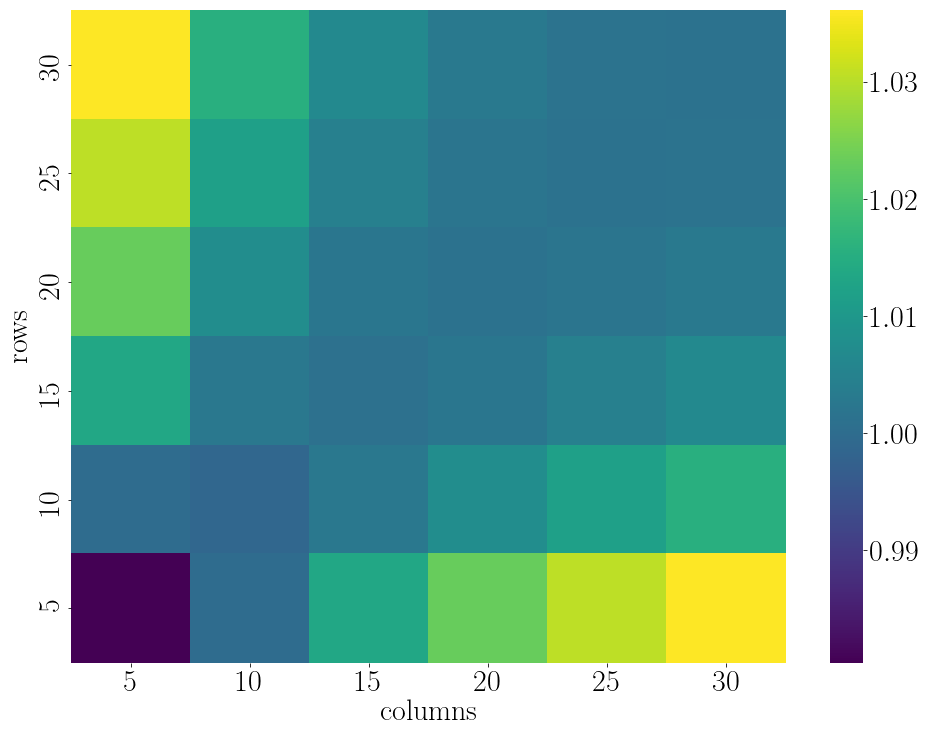

In [30]:
heat = pd.DataFrame(columns=['rows', 'cols', 'spatial_strengths'])
heat['rows'] = graph_rows
heat['cols'] = graph_cols
heat['spatial_strengths'] = spatial_strengths
heatmap = heat.pivot('rows', 'cols', 'spatial_strengths')
heatmap = heatmap.iloc[::-1]
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
#sns.heatmap(heatmap, cmap='viridis', vmin=0.9, vmax=1.1)
sns.heatmap(heatmap, cmap='viridis')

ax.set_xlabel('columns')
ax.set_ylabel('rows')
plt.savefig('figures/lattice_spatial_strength1.pdf', bbox_inches='tight')

Average Spatial Strength: 0.998742857143
Average Spatial Strength: 0.998742857143


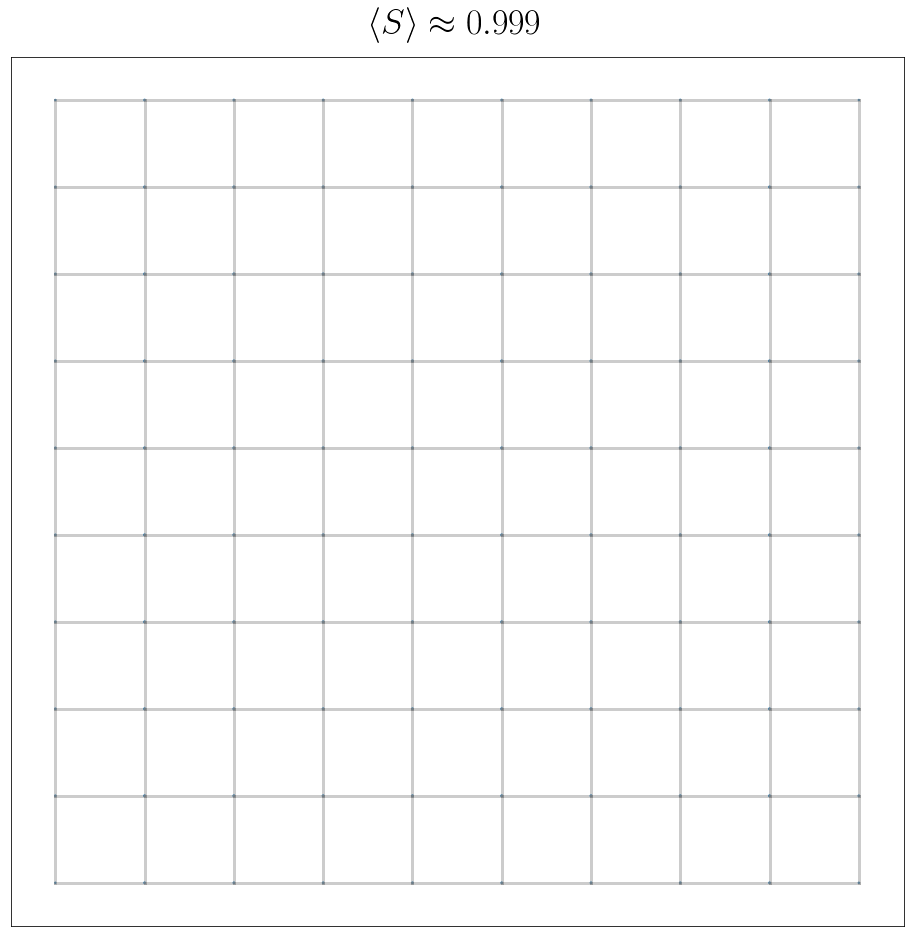

In [4]:
lattice = generate_lattice(rows=10, columns=10)
centralities, _ = report_spatial_strength_centrality(lattice, pbc=False, graph=False, ret=True, normalized=4)
graph_spatial_network_plot_valued(lattice, False, True, ss_title=True, linewidth=3, alpha=0.4)

In [29]:
branches = [1, 2, 3, 4, 5, 6, 7]
layers = [2, 3, 4, 5]
graph_rows = []
graph_cols = []
spatial_strengths = []
for layer in layers:
    for branch in branches:
        print('branch: ', branch, ', layer: ', layer)
        g = generate_web(layers=layer, branches=branch)
        centrality, spatial_strength = report_spatial_strength_centrality(g, pbc=False, ret=True, graph=False, print_result=False, normalized=4)
        spatial_strengths.append(spatial_strength)
        graph_rows.append(branch)
        graph_cols.append(layer)


branch:  1 , layer:  2
branch:  2 , layer:  2
branch:  3 , layer:  2
branch:  4 , layer:  2
branch:  5 , layer:  2
branch:  6 , layer:  2
branch:  7 , layer:  2
branch:  1 , layer:  3
branch:  2 , layer:  3
branch:  3 , layer:  3
branch:  4 , layer:  3
branch:  5 , layer:  3
branch:  6 , layer:  3
branch:  7 , layer:  3
branch:  1 , layer:  4
branch:  2 , layer:  4
branch:  3 , layer:  4
branch:  4 , layer:  4
branch:  5 , layer:  4
branch:  6 , layer:  4
branch:  7 , layer:  4
branch:  1 , layer:  5
branch:  2 , layer:  5
branch:  3 , layer:  5
branch:  4 , layer:  5
branch:  5 , layer:  5
branch:  6 , layer:  5
branch:  7 , layer:  5


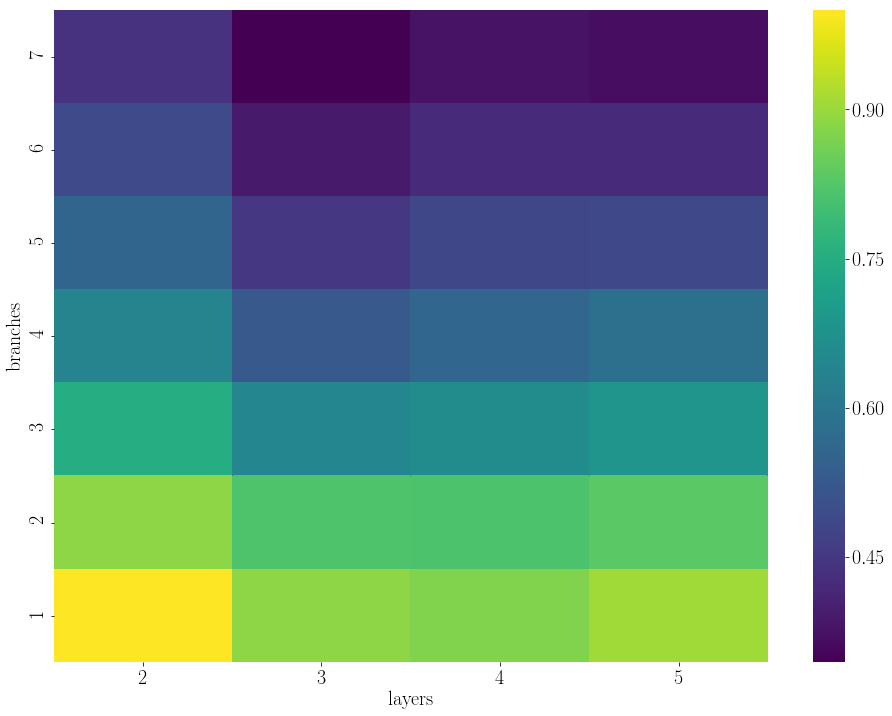

In [30]:
heat = pd.DataFrame(columns=['rows', 'cols', 'spatial_strengths'])
heat['branches'] = graph_rows
heat['layers'] = graph_cols
heat['spatial_strengths'] = spatial_strengths
heatmap = heat.pivot('branches', 'layers', 'spatial_strengths')
heatmap = heatmap.iloc[::-1]
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(heatmap, cmap='viridis')
ax.set_xlabel('layers')
ax.set_ylabel('branches')


In [47]:
branches = [3]
layers = [2, 3, 4, 5, 6, 7, 8, 9]
graph_rows = []
graph_cols = []
spatial_strengths = []
for layer in layers:
    for branch in branches:
        print('branch: ', branch, ', layer: ', layer)
        g = generate_web(layers=layer, branches=branch)
        centrality, spatial_strength = report_spatial_strength_centrality(g, pbc=False, ret=True, graph=False, print_result=False, normalized=4)
        spatial_strengths.append(spatial_strength)
        graph_rows.append(branch)
        graph_cols.append(layer)


branch:  3 , layer:  2
branch:  3 , layer:  3
branch:  3 , layer:  4
branch:  3 , layer:  5
branch:  3 , layer:  6
branch:  3 , layer:  7
branch:  3 , layer:  8
branch:  3 , layer:  9


MemoryError: 

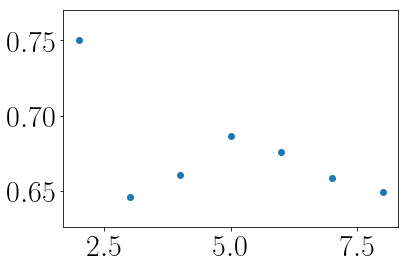

In [46]:
plt.scatter(graph_cols, spatial_strengths)

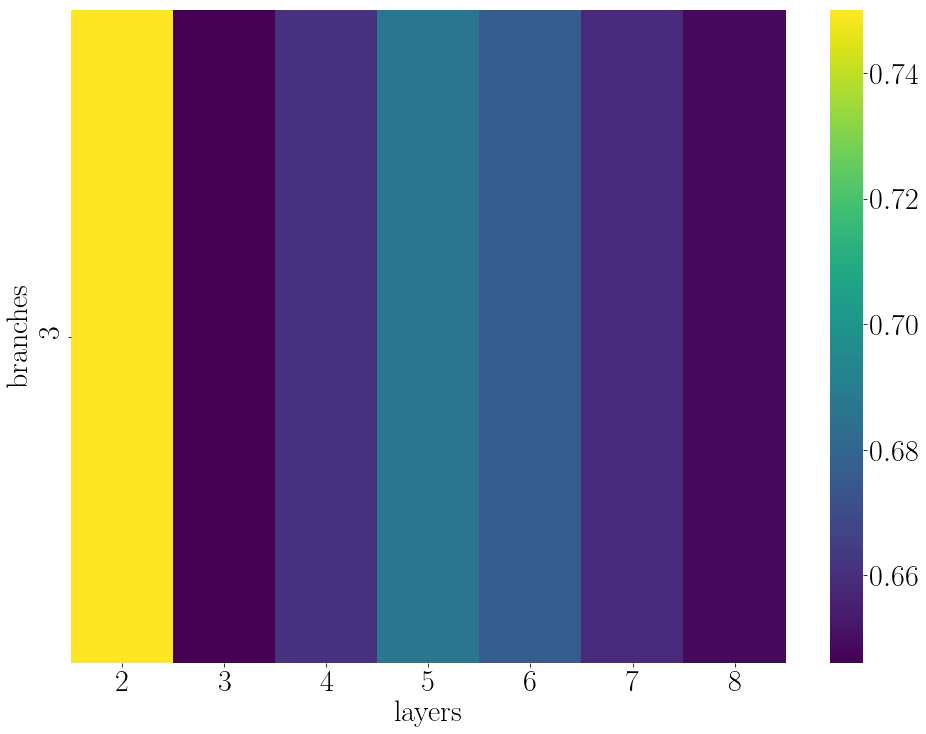

In [43]:
heat = pd.DataFrame(columns=['rows', 'cols', 'spatial_strengths'])
heat['branches'] = graph_rows
heat['layers'] = graph_cols
heat['spatial_strengths'] = spatial_strengths
heatmap = heat.pivot('branches', 'layers', 'spatial_strengths')
heatmap = heatmap.iloc[::-1]
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(1, 1, 1)
sns.heatmap(heatmap, cmap='viridis')
ax.set_xlabel('layers')
ax.set_ylabel('branches')


Average Spatial Strength: 0.686694116237
Average Spatial Strength: 0.686694116237


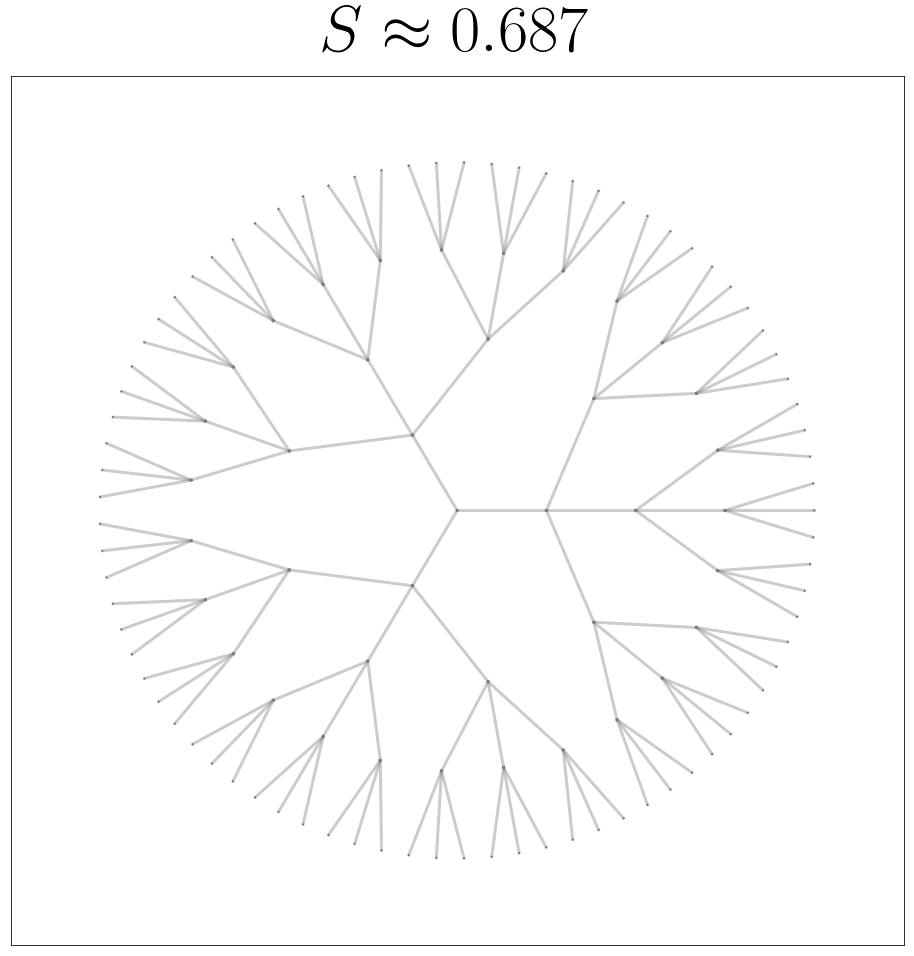

In [14]:
web = generate_web()
centralities, _ =report_spatial_strength_centrality(web, pbc=False, graph=False, ret=True, normalized=4)
graph_spatial_network_plot_valued(web, graph_edges=True, pbc=False, ss_title=True, linewidth=3, alpha=0.4)

In [11]:
#Load all spatial strengths
# spatial_strength_data = {
#     'geographical': pickle.load(open('datasets/results/spatial models/geographical_threshold_spatial_strengths.pickle', 'rb')),
#     'preferential': pickle.load(open('datasets/results/spatial models/preferential_attachment_spatial_strengths.pickle', 'rb')),
#     'configuration': pickle.load(open('datasets/results/spatial models/spatial_configuration_spatial_strengths.pickle', 'rb')),
# }

preferential =  pickle.load(open('datasets/results/spatial models/PA_all_spatial_strengths', 'rb'))[1000]

spatial_strength_data = {
    'geographical': pickle.load(open('datasets/results/spatial models/geographical_threshold_spatial_strengths.pickle', 'rb')),
    'preferential': {},
    'configuration': pickle.load(open('datasets/results/spatial models/n1000_spatconf_spat', 'rb')),
}

for beta in [0,1,2,3,4]:
    spatial_strength_data['preferential'][-beta] = preferential[beta]

r = pd.DataFrame(columns=['type', 'n', 'beta', 'spatial_strength'])

spatial_strength_results = {
}

In [6]:
spatial_strength_data

{'configuration': {'-0.5': [0.65155281021006883,
   0.62839167108443172,
   0.66635237222456045,
   0.66484434060568587,
   0.61854507987209251,
   0.64919376775500537,
   0.65577856554819003,
   0.62957538786162726,
   0.63452031671052711,
   0.61636859763057361,
   0.64441922569584786,
   0.63327985008530419,
   0.63045224811002054,
   0.63749882373329658,
   0.65792328782805931,
   0.65052592709633528,
   0.65423579926515274,
   0.648771604122519,
   0.66367605978441713,
   0.74075042835445304,
   0.64585561266237901,
   0.63502892222412488,
   0.6254781859177061,
   0.62720802153296029,
   0.61769605853056975,
   0.66658078807914156,
   0.65052303051256544,
   0.6257689916536362,
   0.63912319295977182,
   0.68125781514625405],
  '-1.0': [0.65196558702410135,
   0.66255618318753462,
   0.67581156931546449,
   0.69707484915545637,
   0.69745584142823036,
   0.70349998415124126,
   0.71514747976768556,
   0.69483533510109363,
   0.68906941745490125,
   0.67484024745211235,
   0.71348

In [22]:
#add geographical model data to dataframe
spatial_graph_keys = ['geographical', 'preferential', 'configuration']
for graph_type in spatial_graph_keys:
    ssm_results = spatial_strength_data[graph_type]
    results_x = []
    results_y = []
    results_range = []
    for beta in ssm_results.keys():
        sum_spatial_strengths = 0
        for i in range(len(ssm_results[beta])):
            sum_spatial_strengths += ssm_results[beta][i]
        avg_spatial_strength = sum_spatial_strengths / len(ssm_results[beta])
        results_x.append(beta)
        results_y.append(avg_spatial_strength)
        
        next_row = r.shape[0]
        r.loc[next_row] = [graph_type, 500, beta, avg_spatial_strength]
        
    results_range.append(np.min(results_y))
    results_range.append(np.max(results_y))
    
    spatial_strength_results[graph_type] = {
        'x': results_x,
        'y': results_y,
        'rng': results_range
    }

    

In [18]:
#not this one
for graph_type in spatial_graph_keys:
    ssm_results = spatial_strength_data[graph_type]
    results_x = []
    results_y = []
    results_range = []
    for beta in ssm_results.keys():      
        next_row = r.shape[0]
        for i in range(len(ssm_results[beta])):
            r.loc[next_row] = [graph_type, 500, beta, ssm_results[beta]]
        
    results_range.append(np.min(results_y))
    results_range.append(np.max(results_y))
    
    spatial_strength_results[graph_type] = {
        'x': results_x,
        'y': results_y,
        'rng': results_range
    }
    
    

ValueError: setting an array element with a sequence

In [21]:
ssm_results[beta]

[0.19353964578353558,
 0.14787164500632641,
 0.17758593358333633,
 0.17019151721862538,
 0.17806720087721295,
 0.14933488298489223,
 0.15903965620296917,
 0.17127847709194841,
 0.16783799030323923,
 0.15910443259185025,
 0.18158125379199763,
 0.19332252703683256,
 0.22437046174634512,
 0.1733691367202902,
 0.18892247032733017,
 0.15557027716089922,
 0.15079160854868237,
 0.17249809195604562,
 0.19068803590133615,
 0.13231022122736011,
 0.16916428431133196,
 0.11455242120376233,
 0.11275497096598069,
 0.17414924436610948,
 0.18847128685446804,
 0.13258491341684486,
 0.17268004610161664,
 0.14235648721456454,
 0.14344491673029472,
 0.1633361074226039]

In [12]:
#add rgg data to dataframe
results = pickle.load(open('datasets/results/rgg/rgg_n10-1000_r001-01_2.pickle', 'rb'))
for i in range(len(results['graph_n'])):
    next_row = r.shape[0]
    r.loc[next_row] = ['rgg', results['graph_n'][i], results['graph_r'][i], results['avg_spatial_strengths'][i]]

In [13]:
#add lattice and web data to dataframe
#lattice
all_scatter['web'] = {
    'ns': [],
    'strengths': []
}
all_scatter['lattice'] = {
    'ns': [],
    'strengths': []
}
rows = [5, 10, 15, 20, 25, 30]
columns = rows
graph_rows = []
graph_cols = []
spatial_strengths = []
for row in rows:
    for col in columns:
        g = generate_lattice(row, col, size=10)
        centrality, spatial_strength = report_spatial_strength_centrality(g, pbc=False, ret=True, graph=False, print_result=False, normalized=4)
        spatial_strengths.append(spatial_strength)
        graph_rows.append(row)
        graph_cols.append(col)
        
        all_scatter['lattice']['ns'].append(row * col)
        all_scatter['lattice']['strengths'].append(spatial_strength)
        
        next_row = r.shape[0]
        r.loc[next_row] = ['lattice', row * col, 0, spatial_strength]
        
#web
branches = [1, 2, 3, 4, 5, 6]
layers = [2, 3, 4, 5]
graph_rows = []
graph_cols = []
spatial_strengths = []
for layer in layers:
    for branch in branches:
        g = generate_web(layers=layer, branches=branch)
        centrality, spatial_strength = report_spatial_strength_centrality(g, pbc=False, ret=True, graph=False, print_result=False, normalized=4)
        spatial_strengths.append(spatial_strength)
        graph_rows.append(branch)
        graph_cols.append(layer)
        
        all_scatter['web']['ns'].append(len(g.nodes))
        all_scatter['web']['strengths'].append(spatial_strength)
        
        next_row = r.shape[0]
        r.loc[next_row] = ['web', branch ** (layer - 1) + 1, 0, spatial_strength]


NameError: name 'all_scatter' is not defined

In [14]:
#add fungal and road data to dataframe
fungal = pickle.load(open('datasets/results/fungal.pickle', 'rb'))
for i in range(len(fungal)):
    next_row = r.shape[0]
    r.loc[next_row] = ['fungal', 0, 0, fungal[i]]
roads = pickle.load(open('datasets/results/roads.pickle', 'rb'))
for i in range(len(roads['all_results'])):
    next_row = r.shape[0]
    r.loc[next_row] = ['roads', 0, 0, roads['all_results'][i]]

In [63]:
len(roads['all_results'])

101

In [15]:
all_scatter = {
    'fungal': {
        'ns': ns,
        'strengths': fungal
    },
    'roads': {
        'ns': ns2,
        'strengths': roads['all_results']
    }
}

NameError: name 'ns' is not defined

In [112]:
pickle.dump(all_scatter, open('datasets/results/strengths_scatter_1', 'wb'))

In [77]:
all_scatter['web']

{'ns': [], 'strengths': []}

In [101]:
rgg2 = {
    'ns': [],
    'strengths': []
}
for i, n in enumerate(all_scatter['rgg']['ns']):
    if(i % 5 == 0):
        rgg2['ns'].append(n)
        rgg2['strengths'].append(all_scatter['rgg']['strengths'][i])

all_scatter['rgg2'] = rgg2

In [106]:
pa_spat = pickle.load(open('graphs/PA/all_spatial_strengths', 'rb'))

In [111]:
all_scatter['PA'] = {
    'ns': [],
    'strengths': []
}
for n in [300, 1000, 3000, 10000]:
    for i in pa_spat[n][3]:
        all_scatter['PA']['ns'].append(n)
        all_scatter['PA']['strengths'].append(i)

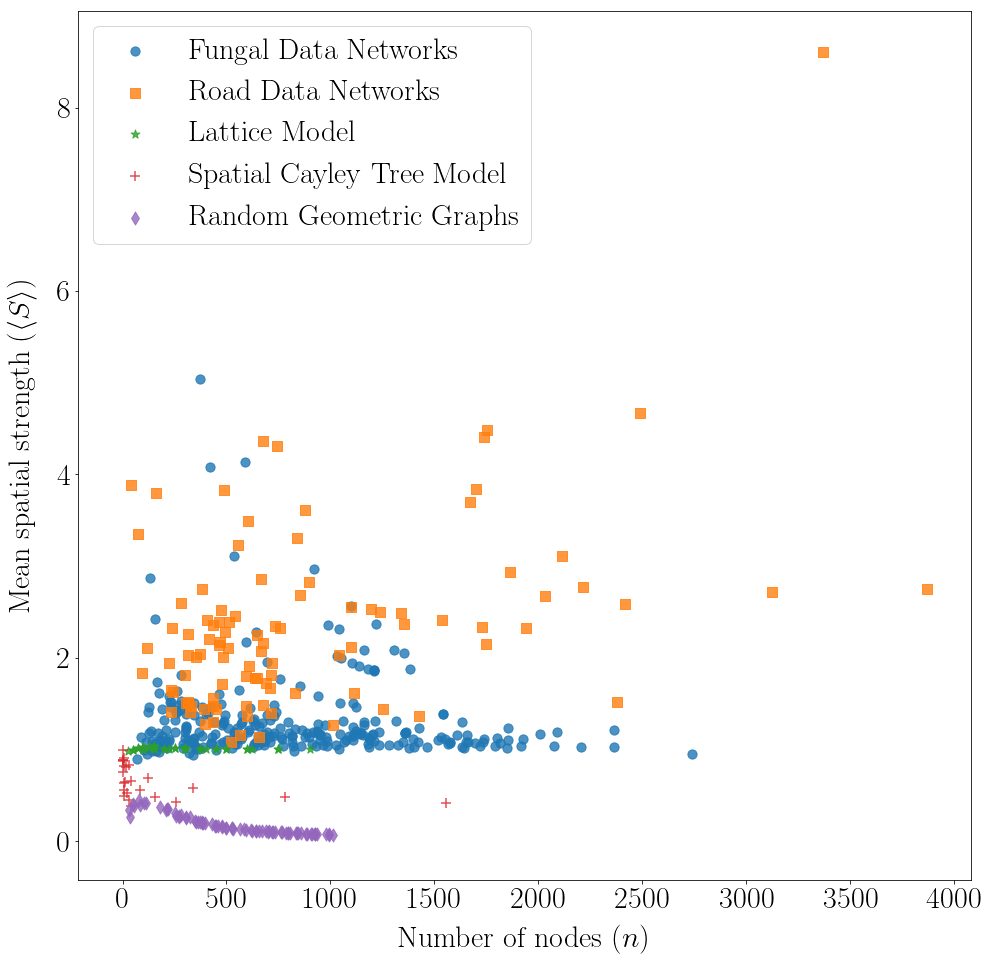

In [43]:
all_scatter = pickle.load(open('datasets/results/strengths_scatter_1', 'rb'))
fig = plt.figure(figsize=(16, 16))
labels = {
    'fungal': 'Fungal Data Networks',
    'roads': 'Road Data Networks',
    'lattice': 'Lattice Model',
    'web': 'Spatial Cayley Tree Model',
    'rgg2': 'Random Geometric Graphs',
    #'PA': 'Spatial Preferential Attachment'
}
for i, label in enumerate(labels):
    plt.scatter(all_scatter[label]['ns'], all_scatter[label]['strengths'], label=labels[label], marker=marker_cycle[i], s=85, alpha=0.8)

plt.xlabel('Number of nodes ($n$)', labelpad=10)
plt.ylabel('Mean spatial strength ({})'.format(r'$\langle S \rangle$'), labelpad=20)
plt.legend()
plt.savefig('figures/spatial_scatter_1.pdf', bbox_inches='tight')

In [ ]:
all_scatter_2 = {
    'fitness': {
        'ns': [],
        'strengths': []
    },
    'BA': {
        'ns': [],
        'strengths': []
    },
    'configuration': {
        
    }
}

In [33]:
fungal_set = pickle.load(open('datasets/results/fungal.pickle', 'rb'))
roads_set = pickle.load(open('datasets/results/roads.pickle', 'rb'))

In [98]:
all_scatter['rgg']

{'ns': [52,
  70,
  73,
  47,
  35,
  57,
  67,
  59,
  37,
  29,
  35,
  25,
  33,
  29,
  26,
  32,
  48,
  27,
  66,
  37,
  113,
  95,
  77,
  101,
  120,
  80,
  93,
  82,
  104,
  93,
  105,
  124,
  105,
  114,
  107,
  82,
  89,
  108,
  101,
  108,
  214,
  206,
  192,
  201,
  216,
  182,
  211,
  204,
  203,
  192,
  207,
  179,
  189,
  220,
  206,
  221,
  212,
  192,
  214,
  180,
  258,
  266,
  274,
  246,
  251,
  272,
  259,
  268,
  268,
  225,
  270,
  238,
  247,
  235,
  225,
  252,
  253,
  246,
  239,
  267,
  324,
  293,
  309,
  301,
  293,
  305,
  295,
  300,
  281,
  305,
  304,
  311,
  280,
  290,
  305,
  280,
  303,
  290,
  279,
  287,
  352,
  374,
  340,
  358,
  344,
  374,
  333,
  346,
  370,
  354,
  350,
  367,
  361,
  349,
  351,
  363,
  327,
  366,
  327,
  344,
  395,
  407,
  401,
  376,
  388,
  383,
  386,
  409,
  407,
  419,
  388,
  395,
  389,
  417,
  402,
  383,
  385,
  409,
  410,
  398,
  432,
  455,
  450,
  444,
  469,
  446,


In [80]:
r2 = r[r['spatial_strength'] <= 4]
r2 = r2[r2['type'] != 'lattice']
r2['type'] = r2['type'].map({
    'geographical': 'Fitness',
    'preferential': 'BA',
    'configuration': 'Configuration',
    'rgg': 'RGG',
    'web': 'Cayley',
    'fungal': 'Fungal',
    'roads': 'City'
})
r2['Spatial Strength'] = r2['spatial_strength']

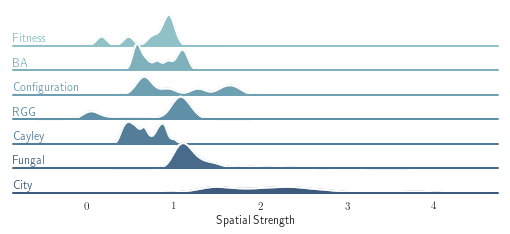

In [81]:
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(r2, row="type", hue="type", aspect=15, height=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "Spatial Strength", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "Spatial Strength", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    labels = {
        'geographical': '(a)',
        'preferential': '(b)',
        'configuration': '(c)',
        'rgg': '(d)',
        'lattice': '(e)',
        'web': '(f)',
        'fungal': '(g)',
        'roads': '(h)'
    }
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "Spatial Strength")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

plt.savefig('figures/spatial_strength_distributions.pdf', bbox_inches='tight')

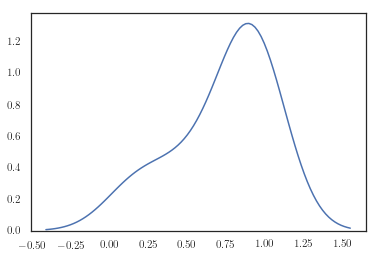

In [62]:
sns.kdeplot(list(r[r['type'] == 'geographical']['spatial_strength']))

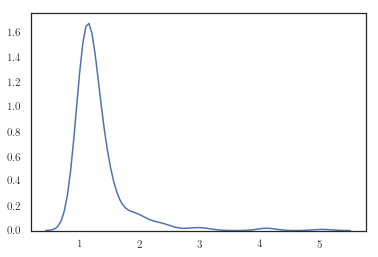

In [63]:
sns.kdeplot(list(r[r['type'] == 'fungal']['spatial_strength']))

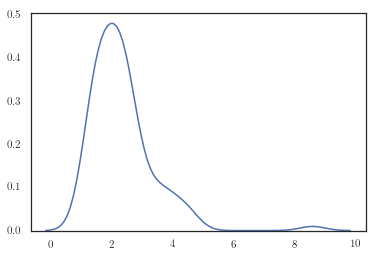

In [64]:
sns.kdeplot(list(r[r['type'] == 'roads']['spatial_strength']))

In [51]:
spatial_strength_data

{'configuration': {'-0.5': [0.65155281021006883,
   0.62839167108443172,
   0.66635237222456045,
   0.66484434060568587,
   0.61854507987209251,
   0.64919376775500537,
   0.65577856554819003,
   0.62957538786162726,
   0.63452031671052711,
   0.61636859763057361,
   0.64441922569584786,
   0.63327985008530419,
   0.63045224811002054,
   0.63749882373329658,
   0.65792328782805931,
   0.65052592709633528,
   0.65423579926515274,
   0.648771604122519,
   0.66367605978441713,
   0.74075042835445304,
   0.64585561266237901,
   0.63502892222412488,
   0.6254781859177061,
   0.62720802153296029,
   0.61769605853056975,
   0.66658078807914156,
   0.65052303051256544,
   0.6257689916536362,
   0.63912319295977182,
   0.68125781514625405],
  '-1.0': [0.65196558702410135,
   0.66255618318753462,
   0.67581156931546449,
   0.69707484915545637,
   0.69745584142823036,
   0.70349998415124126,
   0.71514747976768556,
   0.69483533510109363,
   0.68906941745490125,
   0.67484024745211235,
   0.71348

In [50]:
geo

{'-0.5': [<base_network_extensions.SimpleSpatialGraph at 0x172ff8d0>,
 '-1.0': [<base_network_extensions.SimpleSpatialGraph at 0x19d65590>,
 '-1.5': [<base_network_extensions.SimpleSpatialGraph at 0x1c817a10>,
 '-2.0': [<base_network_extensions.SimpleSpatialGraph at 0x20a25f10>,
 '-2.5': [<base_network_extensions.SimpleSpatialGraph at 0x23493e50>,
 '-3.0': [<base_network_extensions.SimpleSpatialGraph at 0x25f456d0>,
 '0.0': [<base_network_extensions.SimpleSpatialGraph at 0x134df730>,
  <base_network_extensions.SimpleSpatialGraph at 0x171b8570>]}

In [46]:
r2 = r.loc[0:50]

In [47]:
r2

,type,n,beta,spatial_strength
0,geographical,500,0.0,0.165026
1,geographical,500,-0.5,0.476170
2,geographical,500,-1.0,0.750201
3,geographical,500,-1.5,0.875527
4,geographical,500,-2.0,0.932179
5,geographical,500,-2.5,0.957817
6,geographical,500,-3.0,0.974800
7,preferential,500,0.0,0.558083
8,preferential,500,-0.5,0.564849
9,preferential,500,-1.0,0.595938


In [17]:
spatial_strength_results

{}

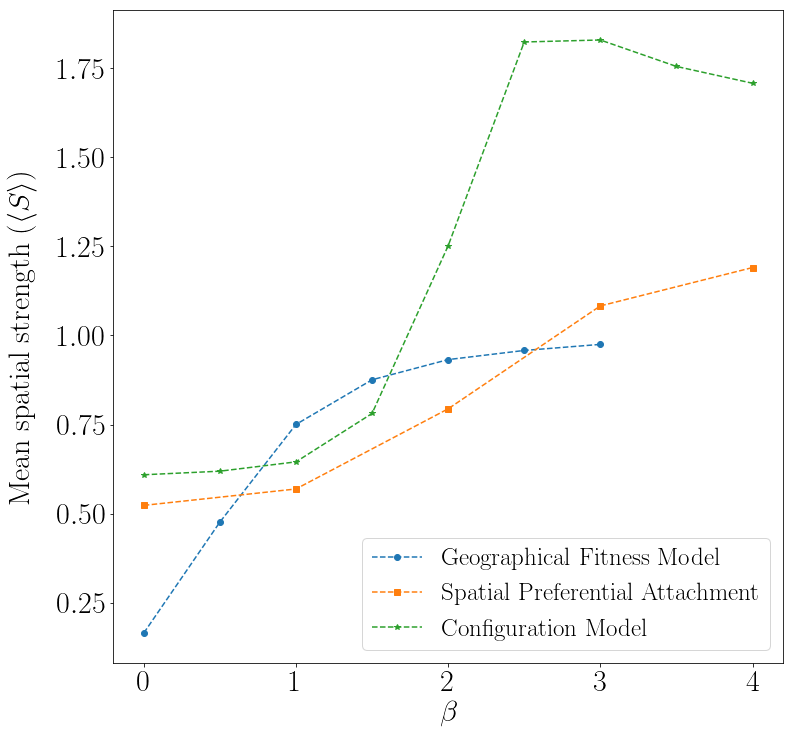

In [29]:
fig = plt.figure(figsize=(12, 12))
labels = {
    'geographical': 'Geographical Fitness Model',
    'preferential': 'Spatial Preferential Attachment',
    'configuration': 'Configuration Model'
}

reverse = False
#DOUBLE CHECK IF BETAS NEED TO BE REVERSED
#reverse betas

if(reverse):
    for graph_type in spatial_graph_keys:
        for i in range(len(spatial_strength_results[graph_type]['x'])):
            spatial_strength_results[graph_type]['x'][i] = -float(spatial_strength_results[graph_type]['x'][i])
    
for i, graph_type in enumerate(spatial_graph_keys):
    plt.plot(spatial_strength_results[graph_type]['x'], spatial_strength_results[graph_type]['y'], str(marker_cycle[i]) + '--', label=labels[graph_type])
plt.legend(fontsize=25)
plt.xlabel(r'$\beta$')
plt.ylabel(r'Mean spatial strength ($\langle S \rangle$)', labelpad=20)
plt.savefig('figures\spatial_model_spatial_strengths2.pdf', bbox_inches='tight')

In [4]:
fig = plt.figure(figsize=(12, 12))
labels = {
    'geographical': 'Fitness',
    'preferential': 'Preferential Attachment',
    'configuration': 'Configuration'
}

#reverse betas
# for graph_type in spatial_graph_keys:
#     for i in range(len(spatial_strength_results[graph_type]['x'])):
#         spatial_strength_results[graph_type]['x'][i] = -float(spatial_strength_results[graph_type]['x'][i])
    
for i, graph_type in enumerate(spatial_graph_keys):
    plt.plot(spatial_strength_results[graph_type]['x'], spatial_strength_results[graph_type]['y'], str(marker_cycle[i]) + '--', label=labels[graph_type], markersize=10)
plt.legend(fontsize=25)
plt.xlabel(r'$\beta$')
plt.ylabel(r'Mean spatial strength ($\langle S \rangle$)')
plt.savefig('figures\spatial_model_spatial_strengths2.pdf', bbox_inches='tight')

NameError: name 'spatial_graph_keys' is not defined

In [20]:
spatial_strength_results['geographical']['x']

['0.0', '-0.5', '-1.0', '-1.5', '-2.0', '-2.5', '-3.0']

Average Spatial Strength: 8.00833333333
Average Spatial Strength: 8.00833333333


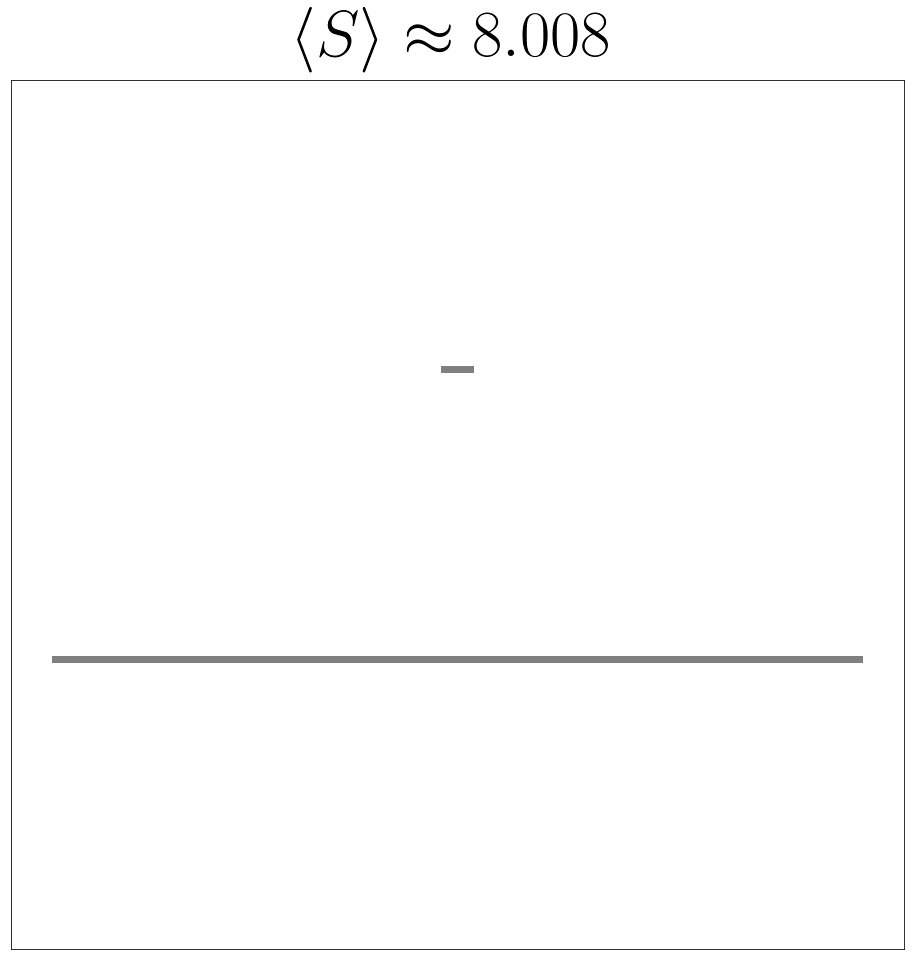

In [35]:
g = SimpleSpatialGraph(size=[100, 6])
g.add_node(coordinate=[5,2])
g.add_node(coordinate=[95, 2])
g.add_node(coordinate=[48.5, 4])
g.add_node(coordinate=[51.5, 4])
g.add_edge(0, 1)
g.add_edge(2, 3)
matplotlib.rc('font', size=55)
graph_spatial_network_plot_valued(g, graph_edges=True, pbc=False, alpha=1, ss_title=True, linewidth=7)
report_spatial_strength_centrality(g, pbc=False, graph=False, ret=False, normalized=4)
plt.savefig('figures/breaking_example_spatial_strength.pdf', bbox_inches='tight')

Average Spatial Strength: 0.300350338168


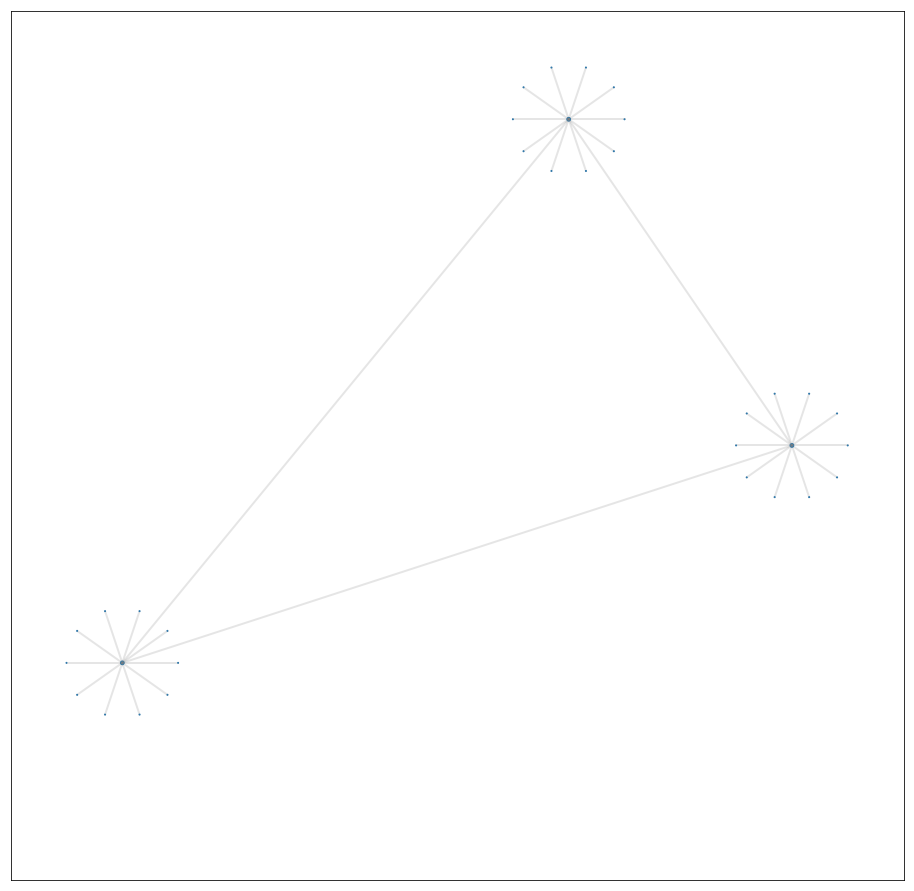

In [31]:
#create a representative hub/leaf network
g = SimpleSpatialGraph(size=[8, 8])
hubs = [[1, 2], [5, 7], [7, 4]]
hub_labels = []
for coord in hubs:
    hub = g.node_count
    hub_labels.append(hub)
    g.add_node(coordinate=coord)
    for i in range(10):
        coord2 = [coord[0] + 0.5 * math.cos(2 * math.pi * (i / 10)), coord[1] + 0.5 * math.sin(2 * math.pi * (i / 10))]
        g.add_node(coordinate=coord2)
        g.add_edge(g.node_count - 1, hub)
for i in range(3):
    for j in range(i, 3):
        g.add_edge(hub_labels[i], hub_labels[j])
graph_spatial_network_plot_valued(g, graph_edges=True, pbc=False, hide_ticks=True)
centralities, spatial_strength = report_spatial_strength_centrality(g, pbc=False, graph=False, ret=True)
hub = g

Average Spatial Strength: 0.998742857143
Average Spatial Strength: 0.686694116237
Average Spatial Strength: 0.300350338168


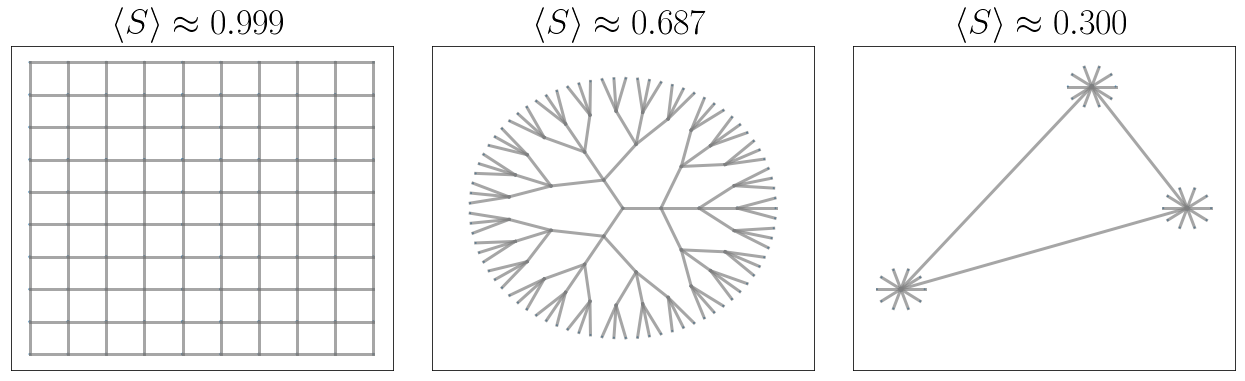

In [32]:
plt.figure(figsize=(18, 6))
matplotlib.rc('font', size=30)

web = generate_web()
lattice = generate_lattice(rows=10, columns=10)


graph_spatial_network_plot_valued(lattice, False, True, pbc=False, subplot=(1, 3, 1), ss_title=True, alpha=0.7, linewidth=3)
graph_spatial_network_plot_valued(web, False, True, pbc=False, subplot=(1, 3, 2), ss_title=True, alpha=0.7, linewidth=3)
graph_spatial_network_plot_valued(hub, False, True, pbc=False, subplot=(1, 3, 3), ss_title=True, alpha=0.7, linewidth=3)
plt.tight_layout()
plt.savefig('figures/toy_network_examples.pdf', bbox_inches='tight')

In [33]:
city = get_city_by_index(20)
fungal = pickle.load(open('datasets/fungal_networks/' + listdir('datasets/fungal_networks')[92], 'rb'))
rgg = pickle.load(open('spatial_rgg_example', 'rb'))

Africa
Tunis.pickle


Average Spatial Strength: 2.33897003875
Average Spatial Strength: 2.27922588355
Average Spatial Strength: 1.2280555887


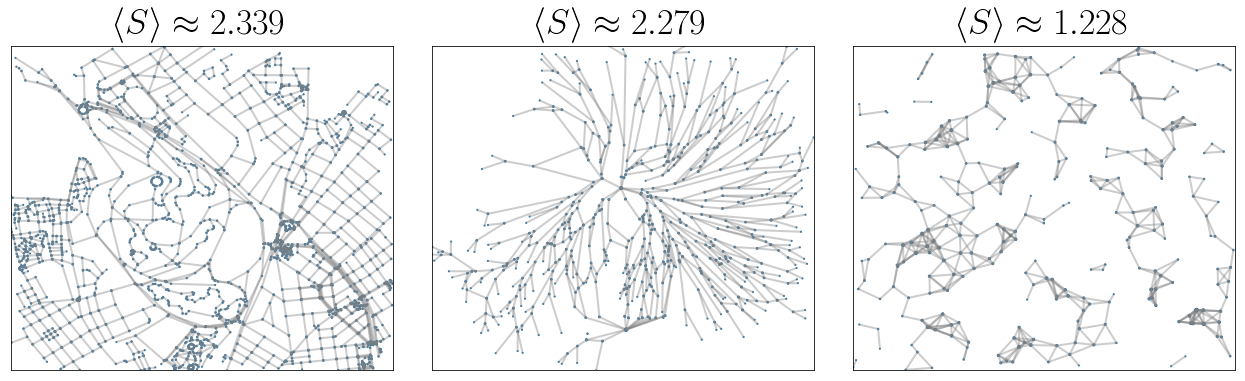

In [34]:
plt.figure(figsize=(18, 6))
graph_spatial_network_plot_valued(city, False, True, pbc=False, subplot=(1, 3, 1), ss_title=True, alpha=0.4)
graph_spatial_network_plot_valued(fungal, False, True, pbc=False, subplot=(1, 3, 2), ss_title=True, alpha=0.4)
graph_spatial_network_plot_valued(rgg, False, True, pbc=False, subplot=(1, 3, 3), ss_title=True, alpha=0.4)
plt.tight_layout()
plt.savefig('figures/data_network_examples.pdf', bbox_inches='tight')

In [37]:
type(city)

NoneType

In [65]:
r.append({'beta': 5, 'n': 500, 'type': 'threshold'})

TypeError: Can only append a Series if ignore_index=True or if the Series has a name

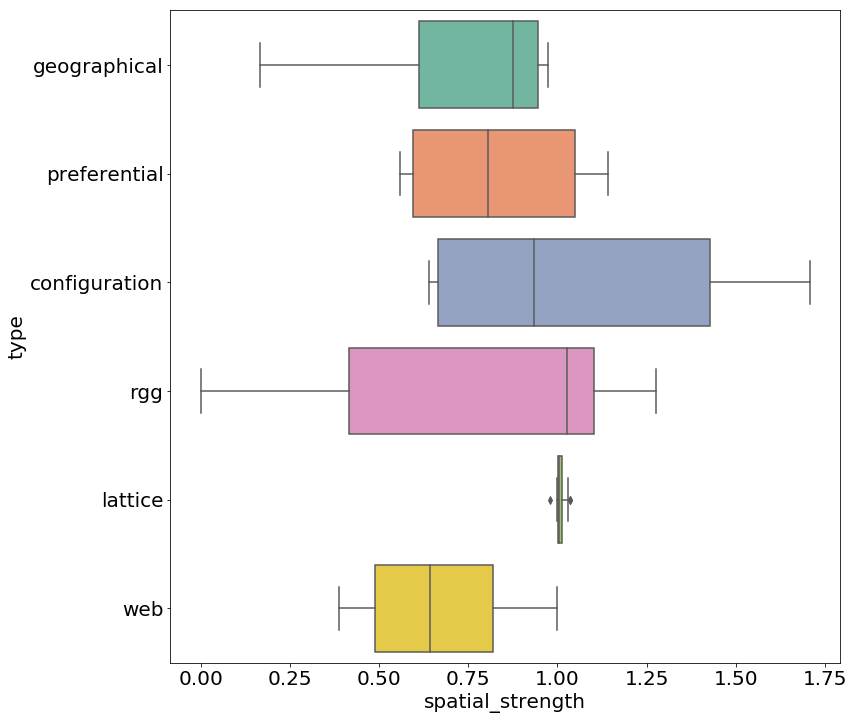

In [110]:
fig = plt.figure(figsize=(12, 12))
ax = sns.boxplot(orient='h', x='spatial_strength', y='type', data=r, palette='Set2')
#ax = sns.swarmplot(orient='h', x='spatial_strength', y='type', data=r, hue='n', dodge=False)


In [79]:


sio.loadmat('datasets/Conductance')

,beta,n,type
0,5,500,threshold
1,-3.0,500,geographical
2,-4.0,500,preferential
3,-3.0,500,configuration


In [ ]:
spatial_strengths = []
file_count = 0
files = len(listdir('datasets/Conductance'))
for file in listdir('datasets/Conductance'):
    print('file ' + str(file_count) + ' of ' + str(files))
    file_count += 1
    g = load_fungal_network(file)
    savename = file.split('.mat')[0]
    pickle.dump(g, open('datasets/fungal_networks/' + savename + '.pickle', 'wb'))
    _, spatial_strength = report_spatial_strength_centrality(g, pbc=False, normalized=4, ret=True, graph=False, print_result=False)
    spatial_strengths.append(spatial_strength)

In [37]:
len(g.nodes)

4

In [39]:
mean_degrees = []
ns = []
for file in listdir('datasets/fungal_networks'):
    print(file)
    g = pickle.load(open('datasets/fungal_networks/' + file, 'rb'))
    mean_degrees.append(average_degree(g))
    ns.append(len(g.nodes))

Ag_M_I+4R_U_N_42d_1.pickle
Pi_M_I_U_N_46d_1.pickle
Pi_M_I_U_N_46d_2.pickle
Pi_M_I_U_N_46d_3.pickle
Pi_M_I_U_N_46d_4.pickle
Pi_M_I_U_N_46d_5.pickle
Pi_M_I_U_N_46d_6.pickle
Pi_M_I_U_N_46d_7.pickle
Pp_M_Tokyo_U_N_26h_1.pickle
Pp_M_Tokyo_U_N_26h_11.pickle
Pp_M_Tokyo_U_N_26h_2.pickle
Pp_M_Tokyo_U_N_26h_4.pickle
Pp_M_Tokyo_U_N_26h_6.pickle
Pp_M_Tokyo_U_N_26h_7.pickle
Pp_M_Tokyo_U_N_26h_9.pickle
Pp_M_UK_U_N_15h_1.pickle
Pp_M_UK_U_N_15h_10.pickle
Pp_M_UK_U_N_15h_11.pickle
Pp_M_UK_U_N_15h_12.pickle
Pp_M_UK_U_N_15h_2.pickle
Pp_M_UK_U_N_15h_6.pickle
Pp_M_UK_U_N_15h_7.pickle
Pp_M_UK_U_N_15h_8.pickle
Pp_M_UK_U_N_15h_9.pickle
Pv_L_I+4xR_Fc_N_155d_1.pickle
Pv_L_I+4xR_Fc_N_155d_2.pickle
Pv_L_I+4xR_Fc_N_155d_3.pickle
Pv_L_I+4xR_Fc_N_208d_1.pickle
Pv_L_I+4xR_Fc_N_208d_2.pickle
Pv_L_I+4xR_Fc_N_208d_3.pickle
Pv_L_I+4xR_Fc_N_36d_1.pickle
Pv_L_I+4xR_Fc_N_36d_2.pickle
Pv_L_I+4xR_Fc_N_36d_3.pickle
Pv_L_I+4xR_Fc_N_57d_1.pickle
Pv_L_I+4xR_Fc_N_57d_2.pickle
Pv_L_I+4xR_Fc_N_57d_3.pickle
Pv_L_I+4xR_Fc_N_78d_1.pick

In [47]:
len(ns)

270

In [49]:
ns[92]

641

In [46]:
print(np.min(ns))
print(np.max(ns))


69
2741


In [44]:
mean_degrees2 = []
ns2 = []
for country in listdir('datasets/road_networks'):
    for file in listdir('datasets/road_networks/' + country):
        print(file)
        g = pickle.load(open('datasets/road_networks/' + country + '/' + file, 'rb'))
        mean_degrees2.append(average_degree(g))
        ns2.append(len(g.nodes))

Abidjan.pickle
Accra.pickle
AddisAbaba.pickle
Alexandria.pickle
Algiers.pickle
Cairo.pickle
CapeTown.pickle
Casablanca.pickle
Dakar.pickle
DarEsSalaam.pickle
Durban.pickle
Ibadan.pickle
Johannesburg.pickle
Kano.pickle
Khartoum.pickle
Kinshasa.pickle
Lagos.pickle
Luanda.pickle
Nairobi.pickle
Pretoria.pickle
Tunis.pickle
Bangkok.pickle
Beijing.pickle
Delhi.pickle
Dhaka.pickle
Guangzhou.pickle
HongKong.pickle
Jakarta.pickle
Karachi.pickle
Kolkata.pickle
Manila.pickle
Mumbai.pickle
Nagoya.pickle
Osaka.pickle
Seoul.pickle
Shanghai.pickle
Shenzhen.pickle
Taipei.pickle
Tehran.pickle
Tokyo.pickle
Wuhan.pickle
Barcelona.pickle
Berlin.pickle
Brussels.pickle
Bucharest.pickle
Budapest.pickle
Hamburg.pickle
London.pickle
Lyon.pickle
Madrid.pickle
Marseille.pickle
Milan.pickle
Munich.pickle
Naples.pickle
Paris.pickle
Prague.pickle
Rome.pickle
Sofia.pickle
Valencia.pickle
Vienna.pickle
Warsaw.pickle
BeloHorizonte.pickle
Bogota.pickle
Brasilia.pickle
BuenosAires.pickle
Caracas.pickle
Fortaleza.pickle


In [36]:
mean_degrees2 = []
ns2 = []
for country in listdir('datasets/road_networks'):
    print(country)
    country_count = 0
    for file in listdir('datasets/road_networks/' + country):
        country_count += 1
    print(country_count)


Africa_2km
21
Asia_2km
20
Europe_2km
20
LatinAmerica_2km
20
US_2km
20


In [48]:
print(np.mean(ns2))
print(np.min(ns2))
print(np.max(ns2))
print(len(ns2))

874.227722772
43
3870
101


In [254]:
spatial_strengths = []
for file in listdir('datasets/fungal_networks'):
    g = pickle.load(open('datasets/fungal_networks/' + file, 'rb'))
    _, spatial_strength = report_spatial_strength_centrality(g, pbc=False, normalized=4, ret=True, graph=False, print_result=False)
    spatial_strengths.append(spatial_strength)

pickle.dump(spatial_strengths, open('datasets/results/fungal.pickle', 'wb'))

In [50]:
fungal = pickle.load(open('datasets/fungal_networks/' + listdir('datasets/fungal_networks')[92], 'rb'))
g2 = pickle.load(open('datasets/fungal_networks/' + listdir('datasets/fungal_networks')[225], 'rb'))


In [51]:
len(g2.nodes)

69

In [45]:
listdir('datasets/fungal_networks')[92]

'Pv_M_I+4R_U_N_21d_4.pickle'

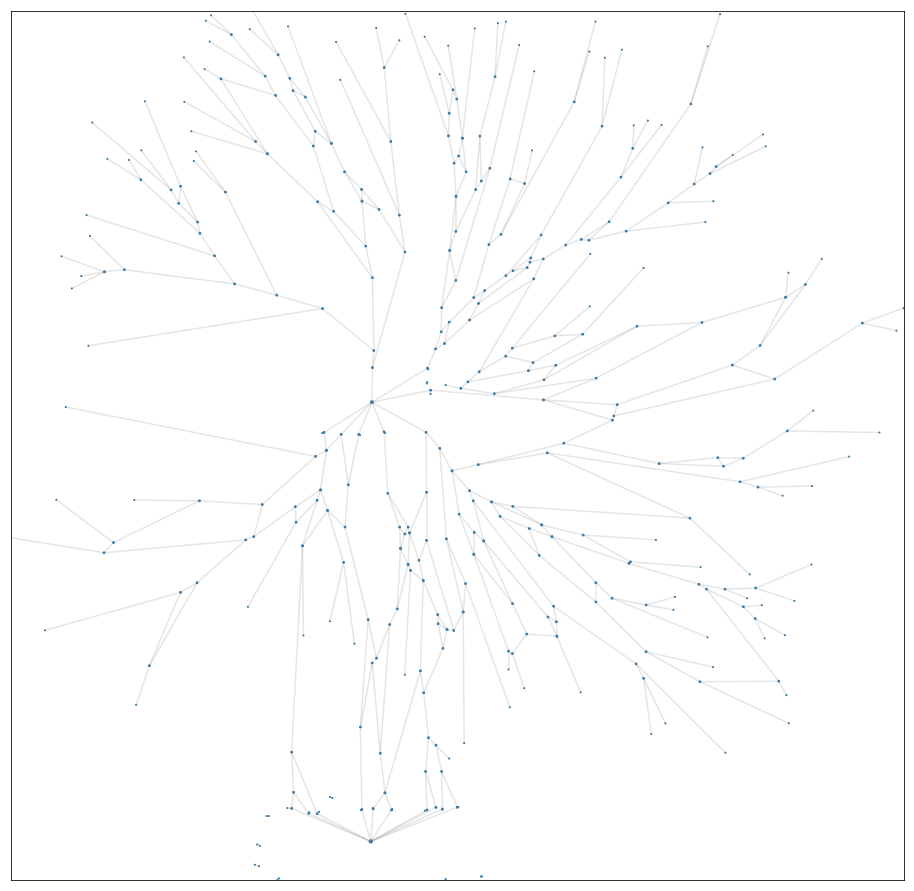

In [20]:
graph_spatial_network_plot_valued(g1, graph_edges=True, pbc=False)

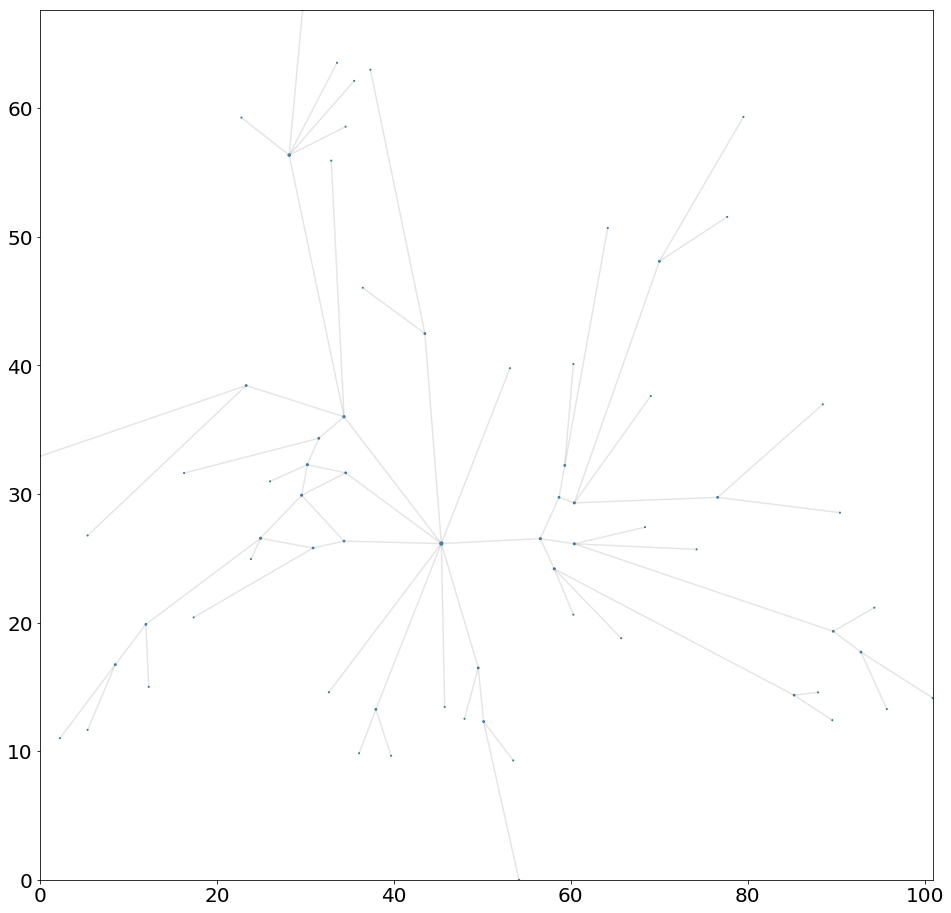

In [188]:
graph_spatial_network_plot_valued(g2, graph_edges=True, pbc=False)

In [22]:
spatial_strengths = []
for country in listdir('datasets/road_data_2km'):
    print('country: ' + country)
    city_count = 0
    cities = []
    for file in listdir('datasets/road_data_2km/' + country):
        if('.pdf') in file:
            city = file.split('.pdf')[0]
            cities.append(city)
        
    for city in cities:
        print(str(city_count) + ' of ' + str(len(cities)))
        city_count += 1
        g = load_city_network(country, city)
        pickle.dump(g, open('datasets/road_networks/' + country + '/' + city.split('_network')[0] + '.pickle', 'wb'))
        _, spatial_strength = report_spatial_strength_centrality(g, pbc=False, normalized=4, ret=True, graph=False, print_result=False)
        spatial_strengths.append(spatial_strength)

country: Africa_2km
0 of 21
1 of 21
2 of 21
3 of 21
4 of 21
5 of 21
6 of 21
7 of 21
8 of 21
9 of 21
10 of 21
11 of 21
12 of 21
13 of 21
14 of 21
15 of 21
16 of 21
17 of 21
18 of 21
19 of 21
20 of 21


KeyboardInterrupt: 

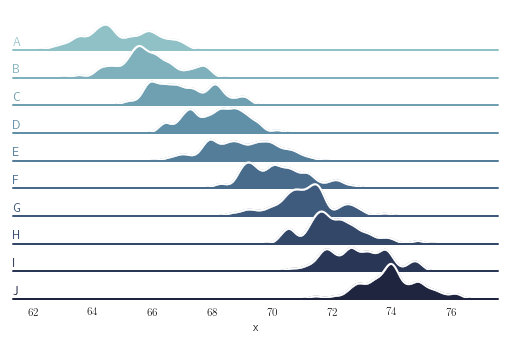

In [7]:
df

,g,x
0,A,64.038123
1,B,66.147050
2,C,66.370011
3,D,68.791019
4,E,70.583534
5,F,69.135114
6,G,72.390092
7,H,73.822191
8,I,73.868785
9,J,72.938377


In [236]:
road_spatial_strengths = {
    'all_results': spatial_strengths
}
city_count = 0
for country in listdir('datasets/road_networks'):
    city_spatial_strengths = []
    
    for i in range(len(listdir('datasets/road_networks/' + country))):
        city_spatial_strengths.append(spatial_strengths[i])
        city_count += 1
        
    road_spatial_strengths[country.split('_2km')[0]] = city_spatial_strengths

#pickle.dump(road_spatial_strengths, open('datasets/results/roads.pickle', 'wb'))

In [22]:
road_spatial_strengths = pickle.load(open('datasets/results/roads.pickle', 'rb'))

In [52]:
city = get_city_by_index(20)

Africa
Tunis.pickle


In [55]:
len(city.nodes)

1731

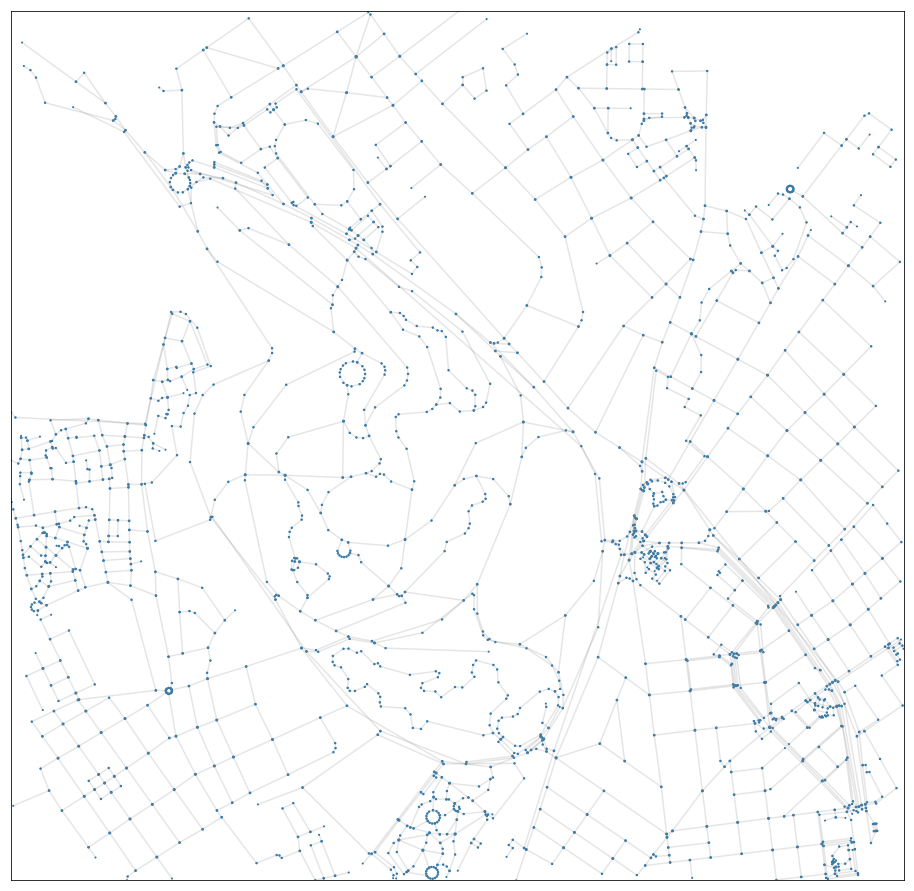

In [23]:
graph_spatial_network_plot_valued(g, graph_edges=True, pbc=False)